# Near Term Energy Demand Forecasting

## Introduction

In this notebook, we use XGBoost for energy demand forecasting. A persistence model is used as the baseline. The dataset used is a timeseries data of hourly load in MWs. 

The dataset used in this project can be found here: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import datetime as dt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import adfuller

import xgboost as xgb
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
import sklearn

# Render figures directly in the notebook:
%matplotlib inline

# Render higher resolution images:
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration and Cleaning

In [2]:
# Reading the datasets

df = pd.read_csv('../data/PJME_hourly.csv', index_col=[0], parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


> The column in the dataframe `PJME_MW` are of type `float64` and no datatype conversions are necessary. We will rename the column to `Actual load` for ease of use. 

In [4]:
df.columns = ['Actual load']

In [5]:
# Checking the statistics

df.describe()

Actual load
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000

> The maximum load seems to be greater than the mean + 3sigma. We will need to check this data for outliers during EDA. Now, we will check for any missing values. 

In [6]:
# Checking for missing values

def find_missing_cols_perc(df, perc):
    '''
    Function to print a list a columns in a dataframe with missing values
    
    Arguments:
    df - dataframe
    perc - percentage of missing values
    
    Prints:
    List of columns with percentage of missing data greater than 'perc'
    
    '''
    print(df.columns[df.isnull().mean() > perc])

In [7]:
find_missing_cols_perc(df, 0), find_missing_cols_perc(df, 0.5)

Index([], dtype='object')
Index([], dtype='object')


(None, None)

> There are no missing values in the dataset, which is good news for us since we dont have to perform any imputation.

## 2. Data Visualization



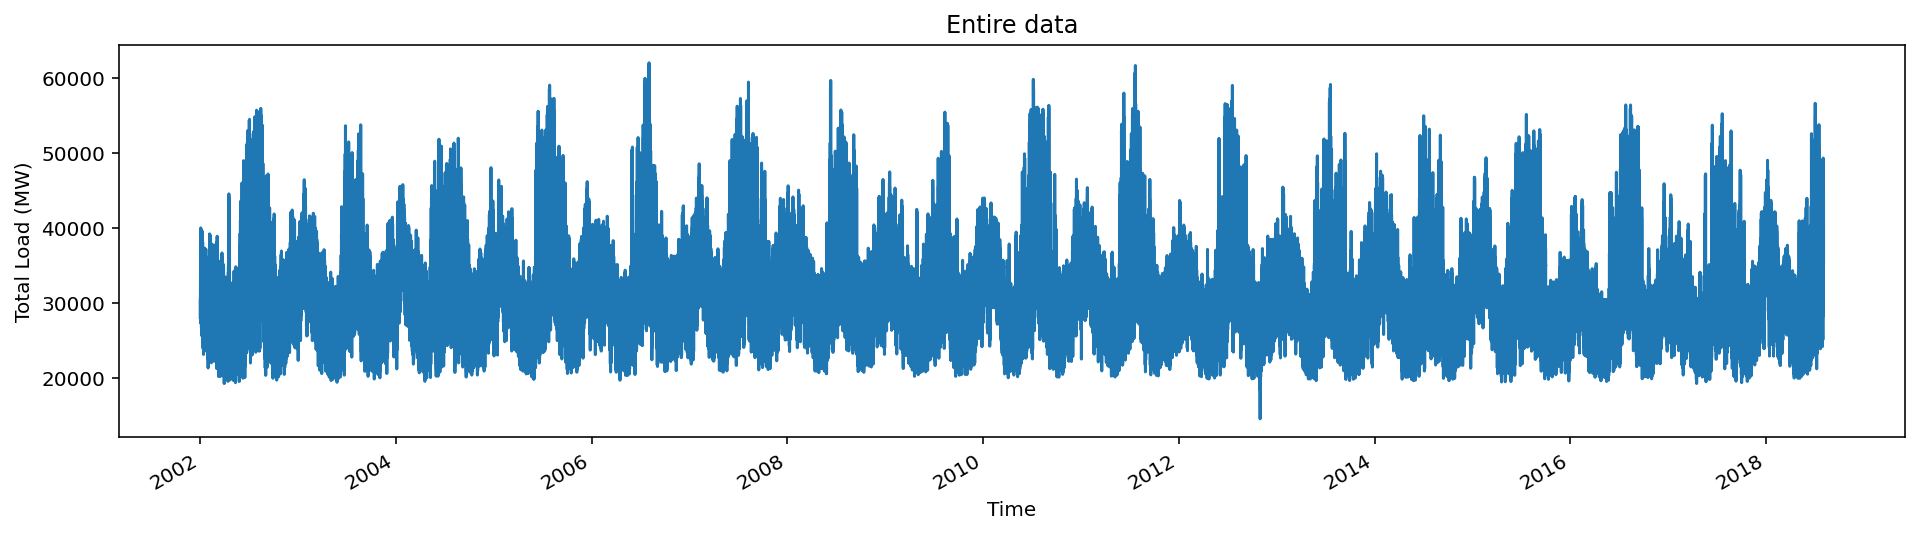

In [8]:
# Time-series visualization

df['Actual load'].plot(figsize=(16,4), title='Entire data')
plt.xlabel('Time')
plt.ylabel('Total Load (MW)')
plt.show()

Text(0, 0.5, 'Total Load (MW)')

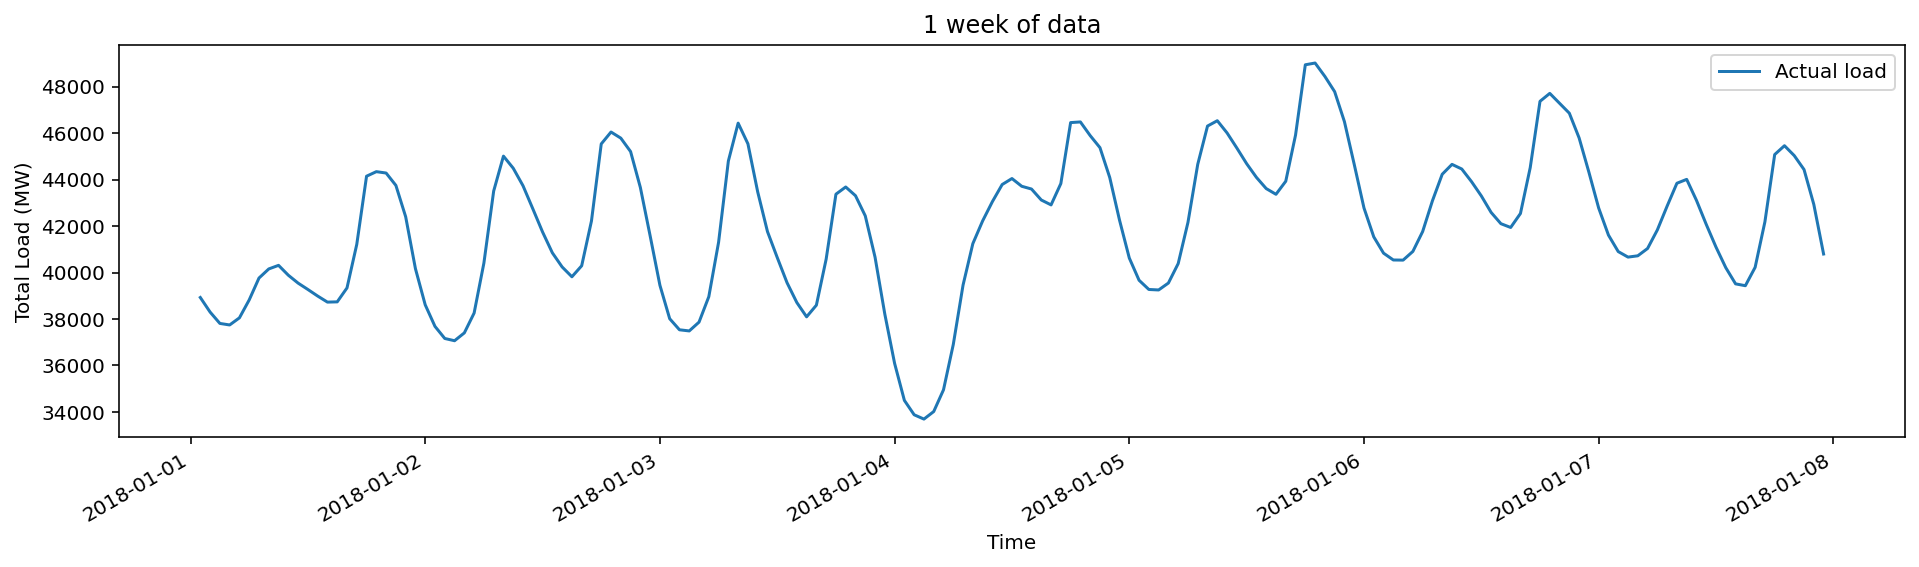

In [9]:
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')].plot(figsize=(16, 4), title='1 week of data')
plt.xlabel('Time')
plt.ylabel('Total Load (MW)')


> Now we will decompose the timeseries. 

> At a high-level, time series data can be thought of as components put together. That is:

> Data = Level + Trend + Seasonality + Noise

> * Level: the average value in the series.
> * Trend: the increasing or decreasing value in the series.
> * Seasonality: the repeating short-term cycle in the series.
> * Noise/Residual: the random variation in the series.

> We will use the statsmodel library to decompose the timseries to the components mentioned above. 

In [10]:
# Given there's no missing data, we can resample the data to daily level
df_daily = df.resample(rule='D').sum()

# Set frequency explicitly to D
df_daily = df_daily.asfreq('D')

df_daily.head(10)

Actual load
Datetime               
2002-01-01     714857.0
2002-01-02     822277.0
2002-01-03     828285.0
2002-01-04     809171.0
2002-01-05     729723.0
2002-01-06     727766.0
2002-01-07     800012.0
2002-01-08     824710.0
2002-01-09     810628.0
2002-01-10     755317.0

Text(0, 0.5, 'Total Load (MW)')

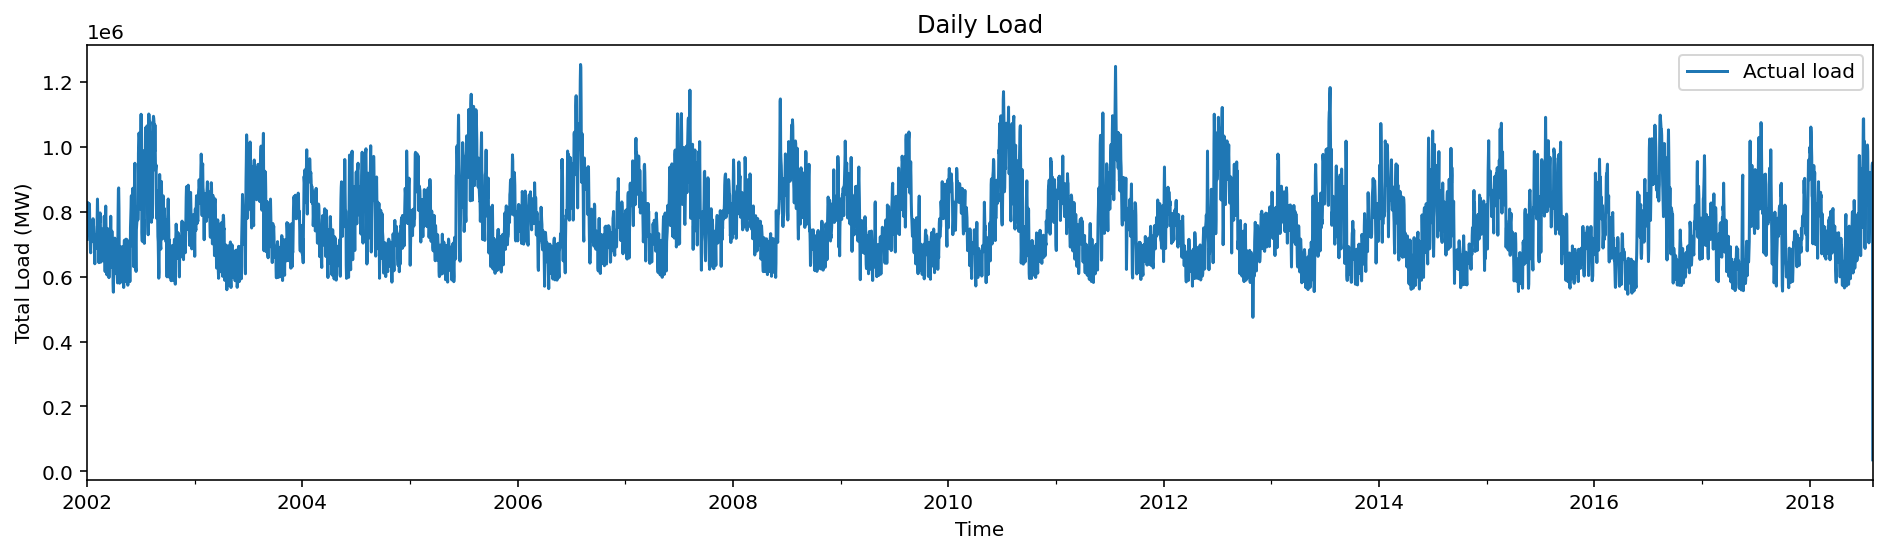

In [11]:
df_daily.plot(figsize=(16,4), title='Daily Load')
plt.xlabel('Time')
plt.ylabel('Total Load (MW)')

> We will have to remove the first and the last points to remove the tail at the end. 

In [12]:
df_daily = df_daily.drop([df_daily.index.min(), df_daily.index.max()])

Text(0, 0.5, 'Total Load (MW)')

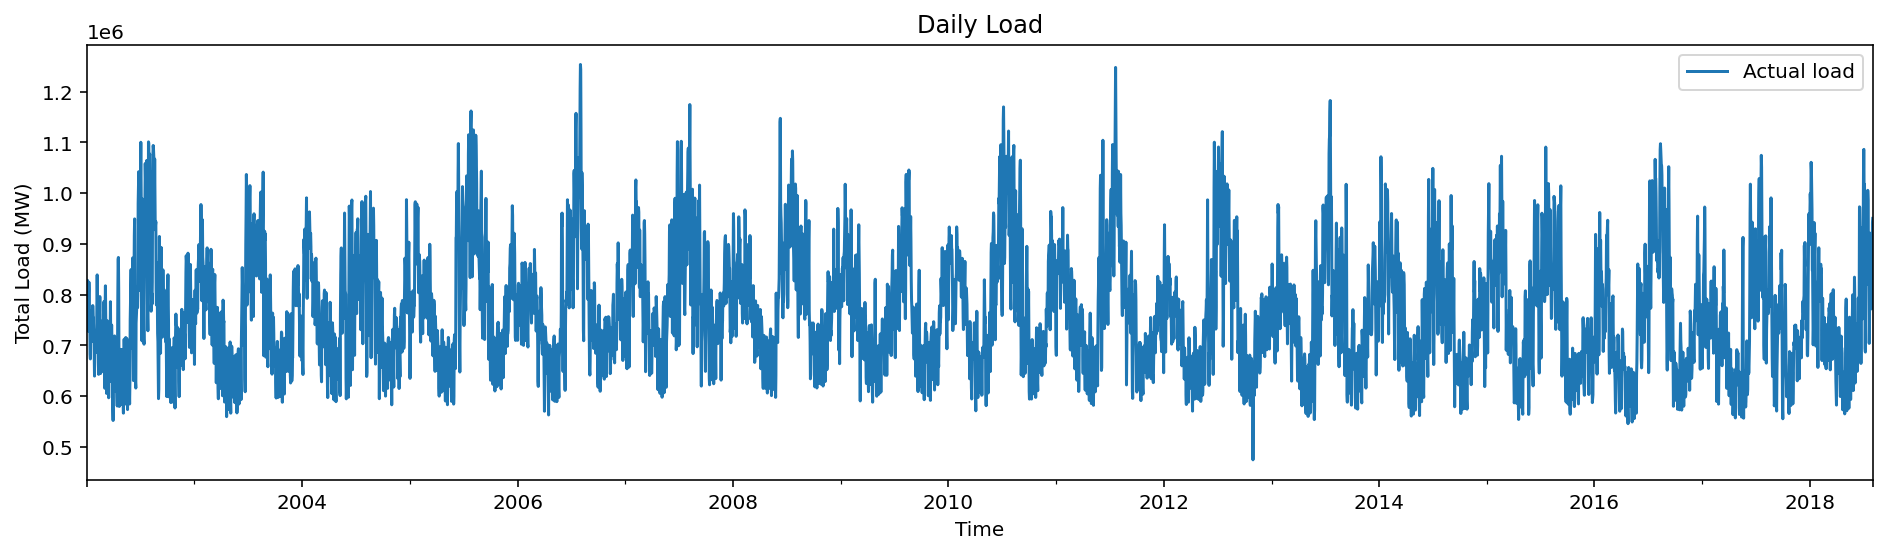

In [13]:
df_daily.plot(figsize=(16,4), title='Daily Load')
plt.xlabel('Time')
plt.ylabel('Total Load (MW)')

> Now we can decompose the time series. 

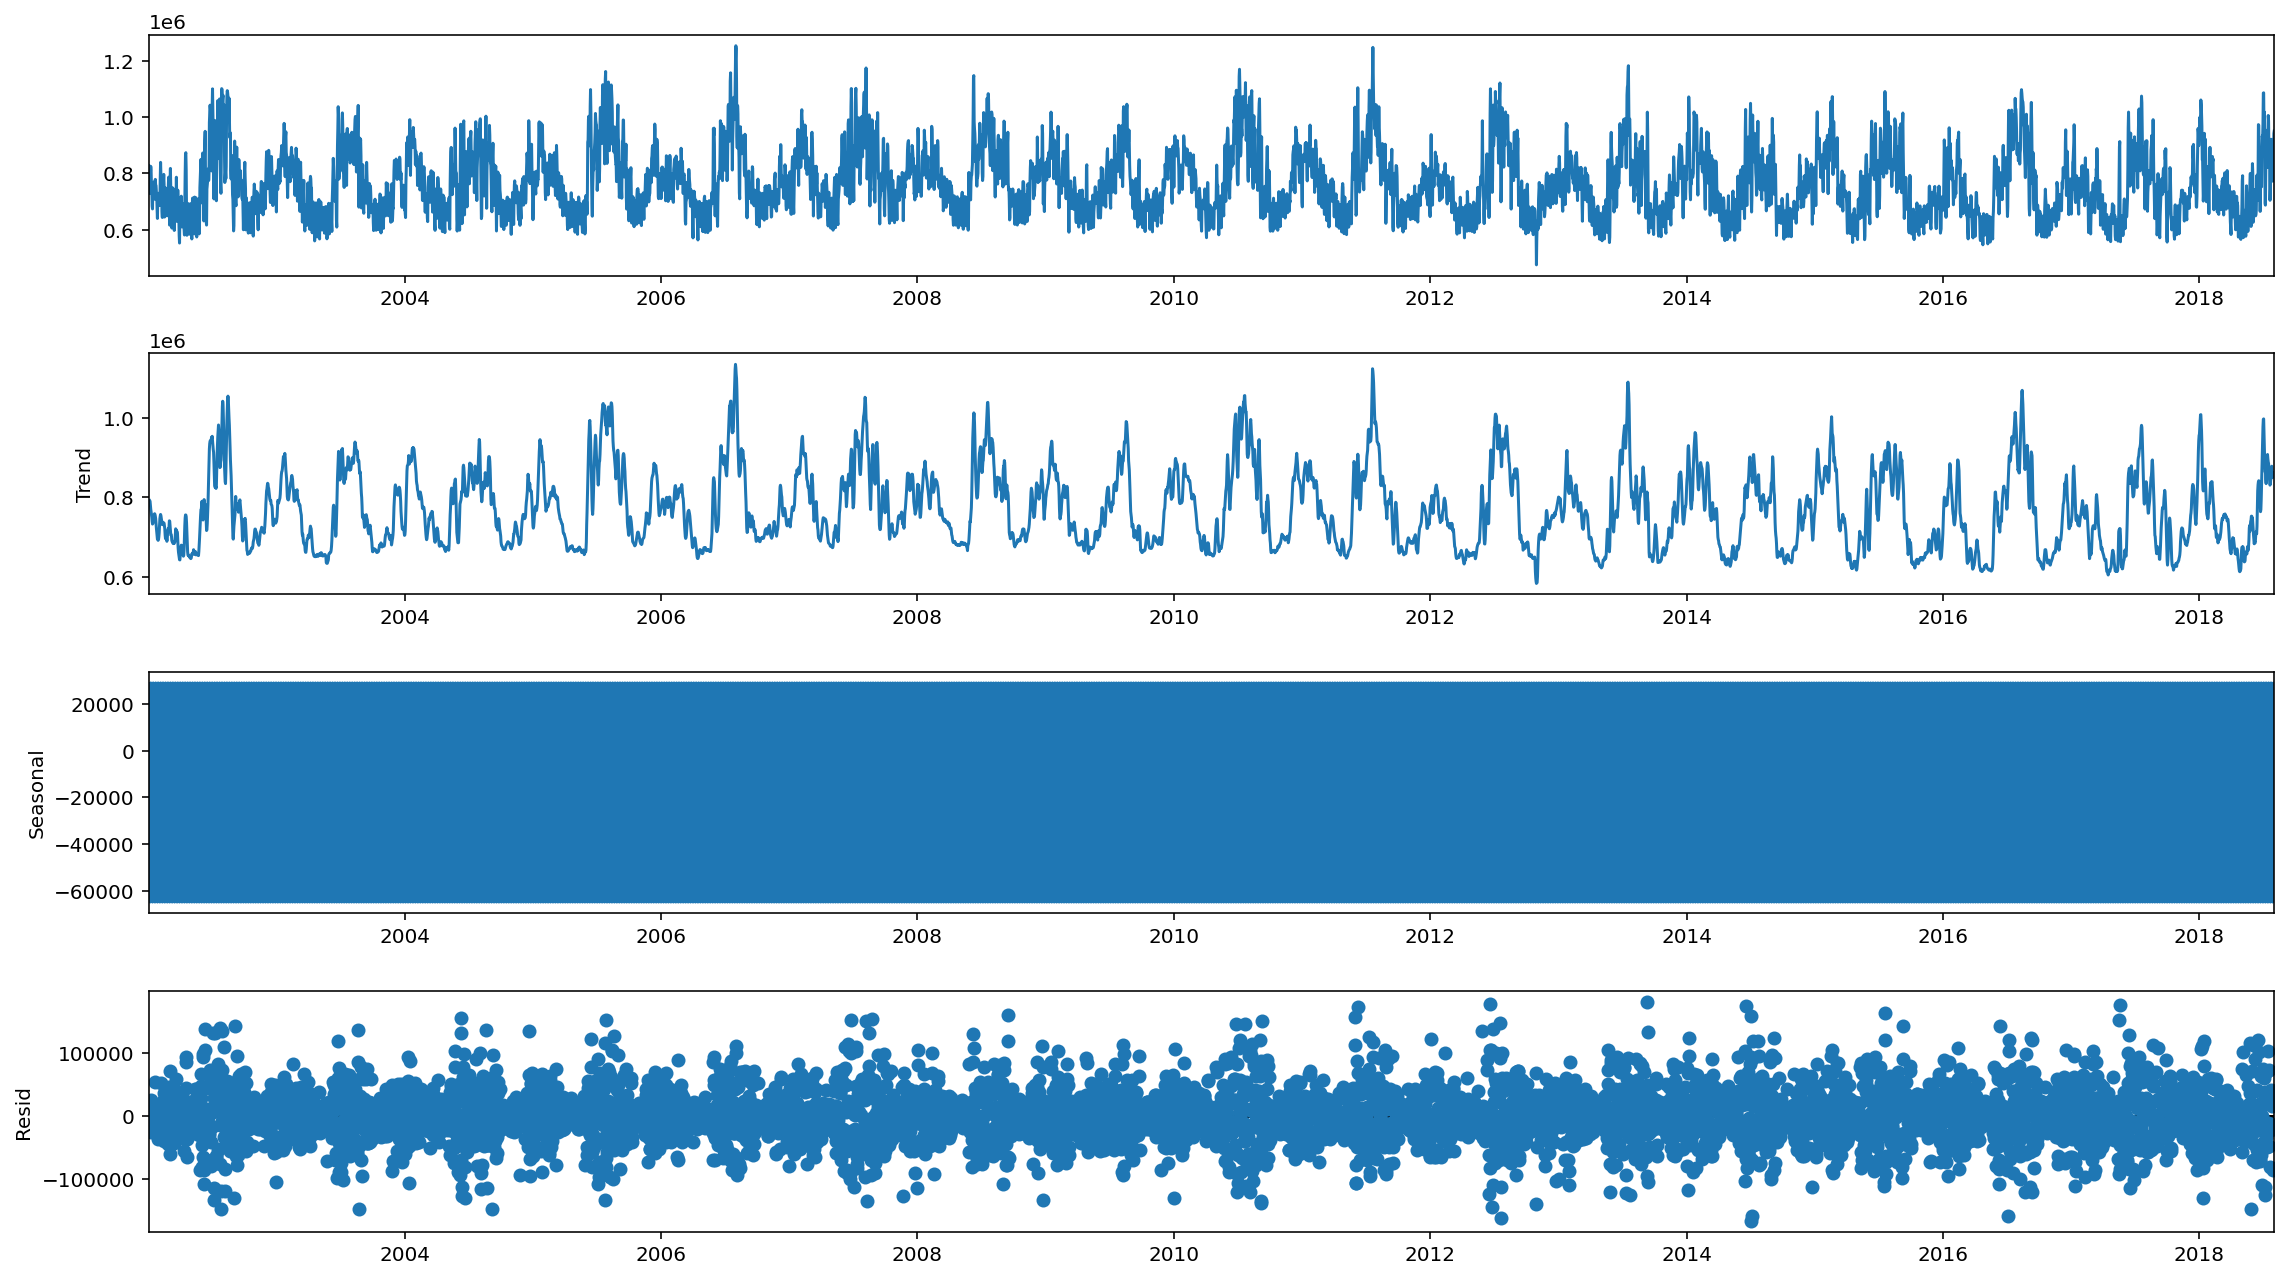

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_daily, model='additive')

fig = decomposition.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

> We are not able to get insights about the seasonal trends here due to the daily granularity. We will try a bigger time window viz. a viz. weekly and monthly. 

In [15]:
df_weekly = df.resample(rule='W').sum()
df_weekly = df_weekly.asfreq('W')
df_weekly.head(10)

Actual load
Datetime               
2002-01-06    4632079.0
2002-01-13    5289881.0
2002-01-20    5284084.0
2002-01-27    5063777.0
2002-02-03    4905010.0
2002-02-10    5233287.0
2002-02-17    5143583.0
2002-02-24    4896214.0
2002-03-03    5017994.0
2002-03-10    4946073.0

Text(0, 0.5, 'Total Load (MW)')

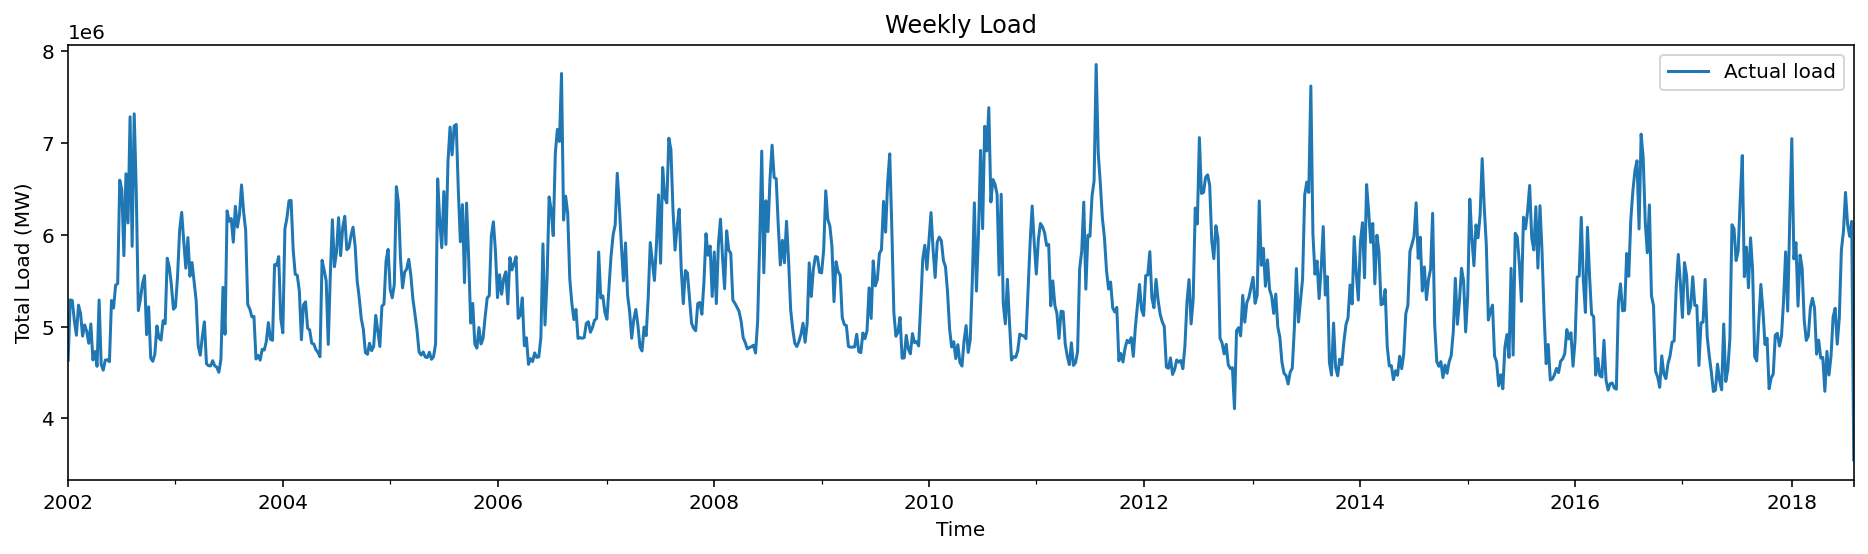

In [16]:
df_weekly.plot(figsize=(16,4), title='Weekly Load')
plt.xlabel('Time')
plt.ylabel('Total Load (MW)')

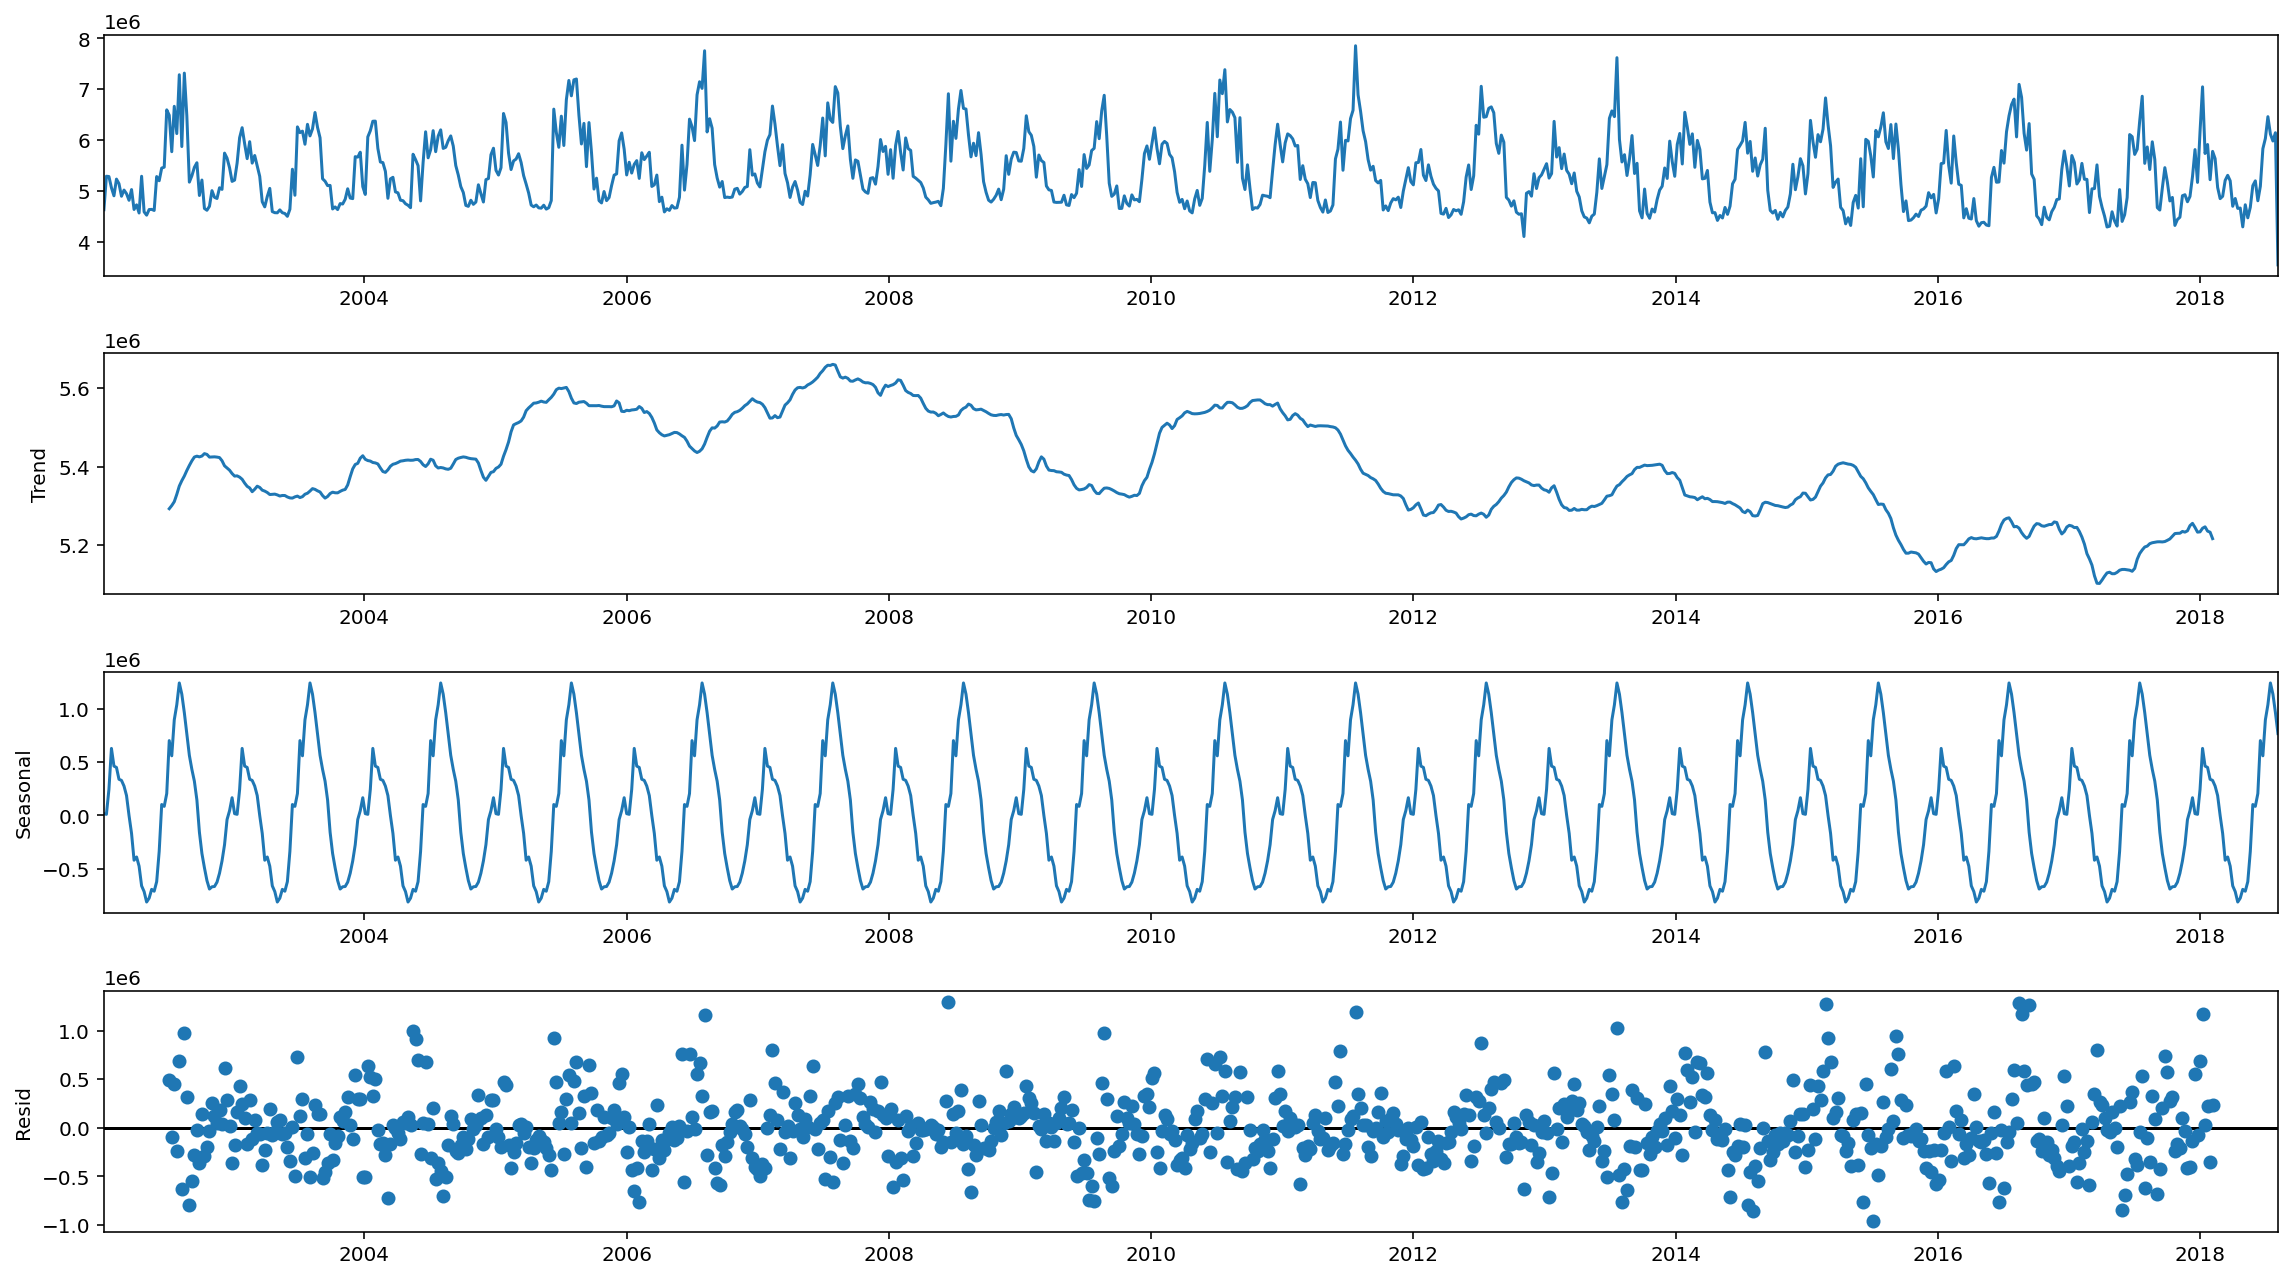

In [17]:
decomposition = seasonal_decompose(df_weekly, model='additive') # Aggregate to weekly level

fig = decomposition.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

> There is cleary a seasonal variation in the total load. Now lets check how this changes when we use monthly granularity. 

In [18]:
df_monthly = df.resample(rule='M').sum()
df_monthly = df_monthly.asfreq('M')
df_monthly.head(10)

Actual load
Datetime               
2002-01-31   23089022.0
2002-02-28   20320720.0
2002-03-31   21483191.0
2002-04-30   20516472.0
2002-05-31   20886798.0
2002-06-30   24181862.0
2002-07-31   28303171.0
2002-08-31   28282432.0
2002-09-30   22522657.0
2002-10-31   21425753.0

Text(0, 0.5, 'Total Load (MW)')

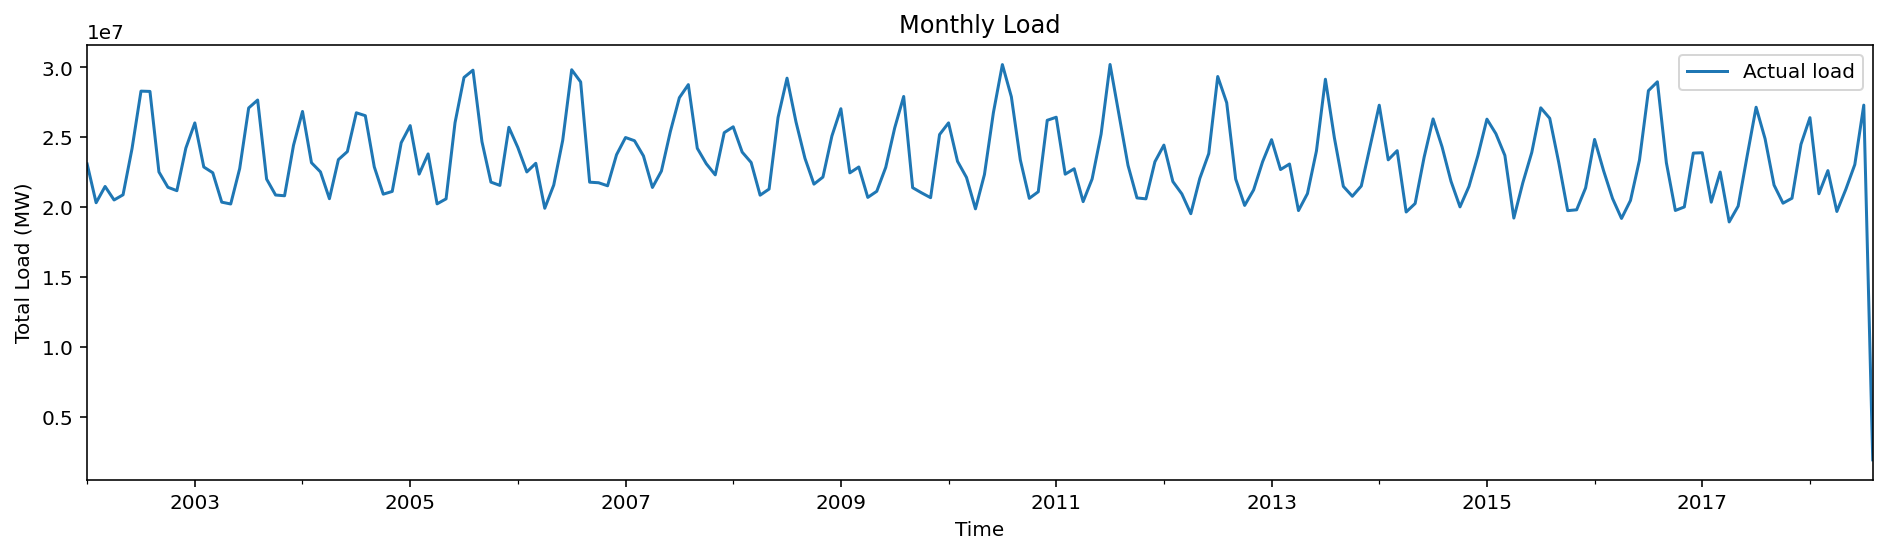

In [19]:
df_monthly.plot(figsize=(16,4), title='Monthly Load')
plt.xlabel('Time')
plt.ylabel('Total Load (MW)')

In [20]:
df_monthly = df_monthly.drop([df_monthly.index.min(), df_monthly.index.max()])

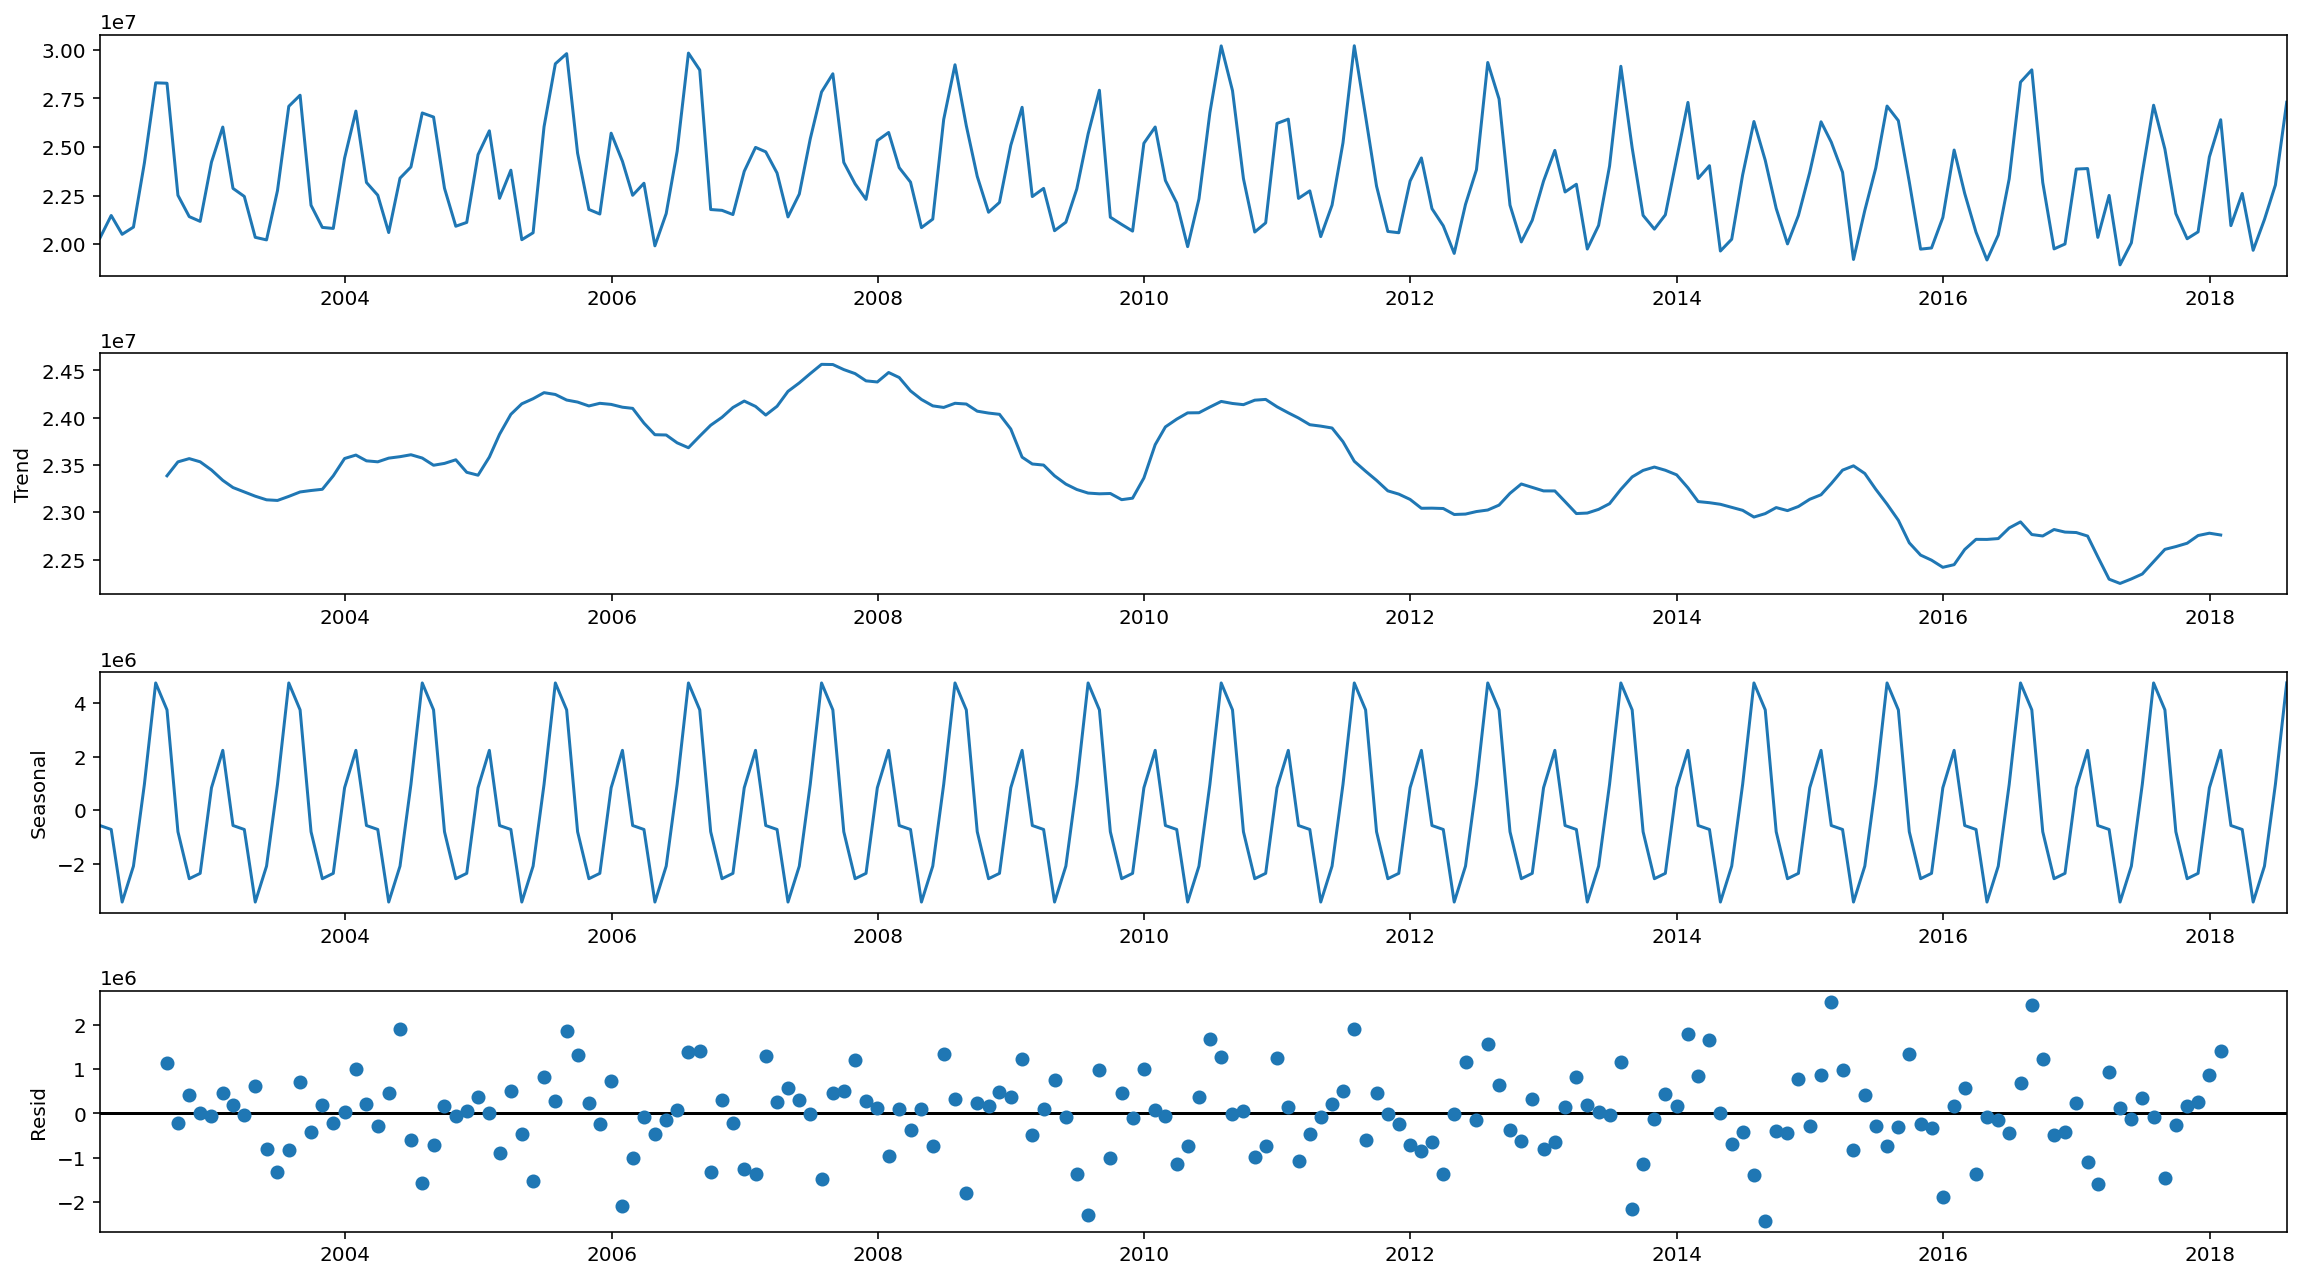

In [21]:
decomposition = seasonal_decompose(df_monthly, model='additive') # Aggregate to weekly level

fig = decomposition.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

> These are some observations from the above decompostions. 
> * Electricity usage has peaks and troughs, indicating that its seasonal and repetitive. 
> * Office hours, weather patterns, holidays etc will affect the electricity usage. 
> * The electricity usage seems to go down in the latter years. This could be due to efficiency improvements, economic factors, demographic changes and changes in policy and regulations. 

In [22]:
# Feature Creation

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_raw = df.copy()
df = create_features(df)


In [23]:
df

Actual load  hour  dayofweek  quarter  month  year  \
Datetime                                                                  
2002-12-31 01:00:00      26498.0     1          1        4     12  2002   
2002-12-31 02:00:00      25147.0     2          1        4     12  2002   
2002-12-31 03:00:00      24574.0     3          1        4     12  2002   
2002-12-31 04:00:00      24393.0     4          1        4     12  2002   
2002-12-31 05:00:00      24860.0     5          1        4     12  2002   
...                          ...   ...        ...      ...    ...   ...   
2018-01-01 20:00:00      44284.0    20          0        1      1  2018   
2018-01-01 21:00:00      43751.0    21          0        1      1  2018   
2018-01-01 22:00:00      42402.0    22          0        1      1  2018   
2018-01-01 23:00:00      40164.0    23          0        1      1  2018   
2018-01-02 00:00:00      38608.0     0          1        1      1  2018   

                     dayofyear  dayofmonth  weekofyear  
Datetime                                                
2002-12-31 01:00:00        365          31           1  
2002-12-31 02:00:00        365          31           1  
2002-12-31 03:00:00        365          31           1  
2002-12-31 04:00:00        365          31           1  
2002-12-31 05:00:00        365          31           1  
...                        ...         ...         ...  
2018-01-01 20:00:00          1           1           1  
2018-01-01 21:00:00          1           1           1  
2018-01-01 22:00:00          1           1           1  
2018-01-01 23:00:00          1           1           1  
2018-01-02 00:00:00          2           2           1  

[145366 rows x 9 columns]

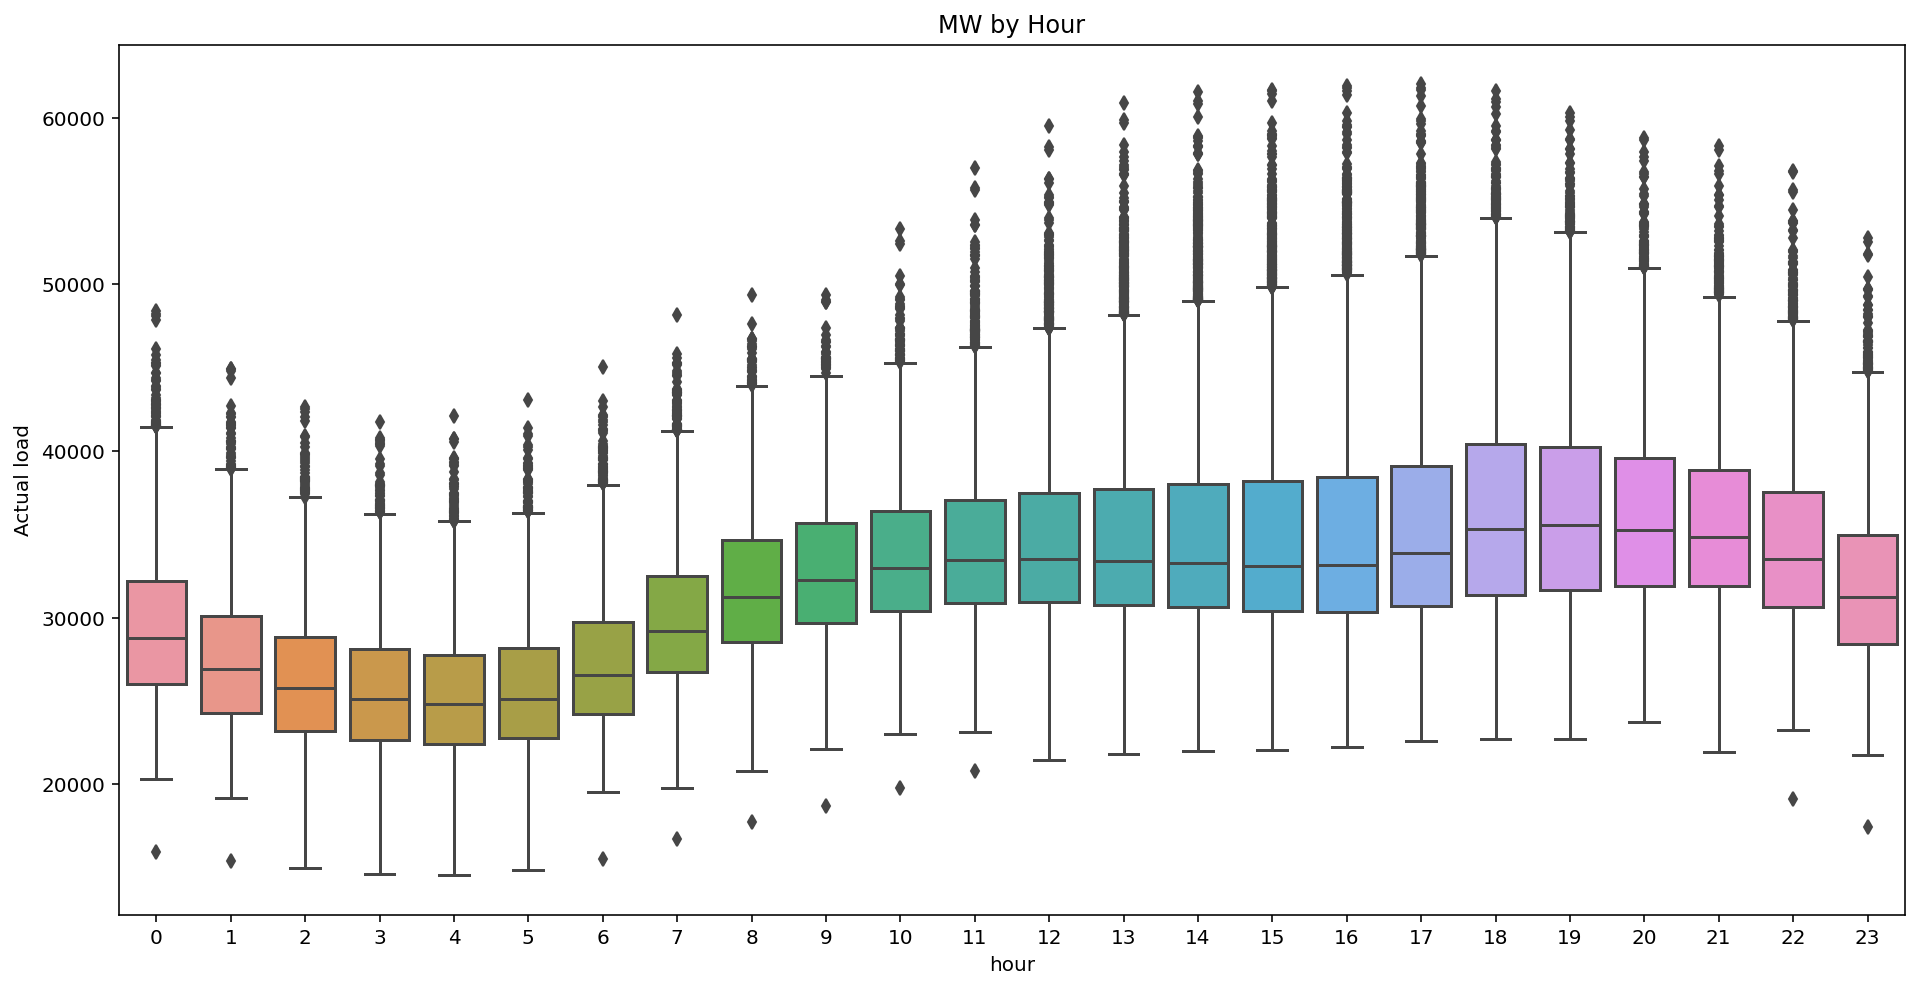

In [24]:
# Visualizing the relationship between the timeseries features and the actual load

fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=df, x='hour', y='Actual load')
ax.set_title('MW by Hour')
plt.show()

> * The minimum load happens during the early hours of the day (when everyone is sleeping, businesses are closed etc).
> * The maximum load seems to occur post noon.
> * The busiest time of the grid is from 11 AM to 9 PM. 
> * The effect of weather on the changing load through out the day will be interesting to look at. 


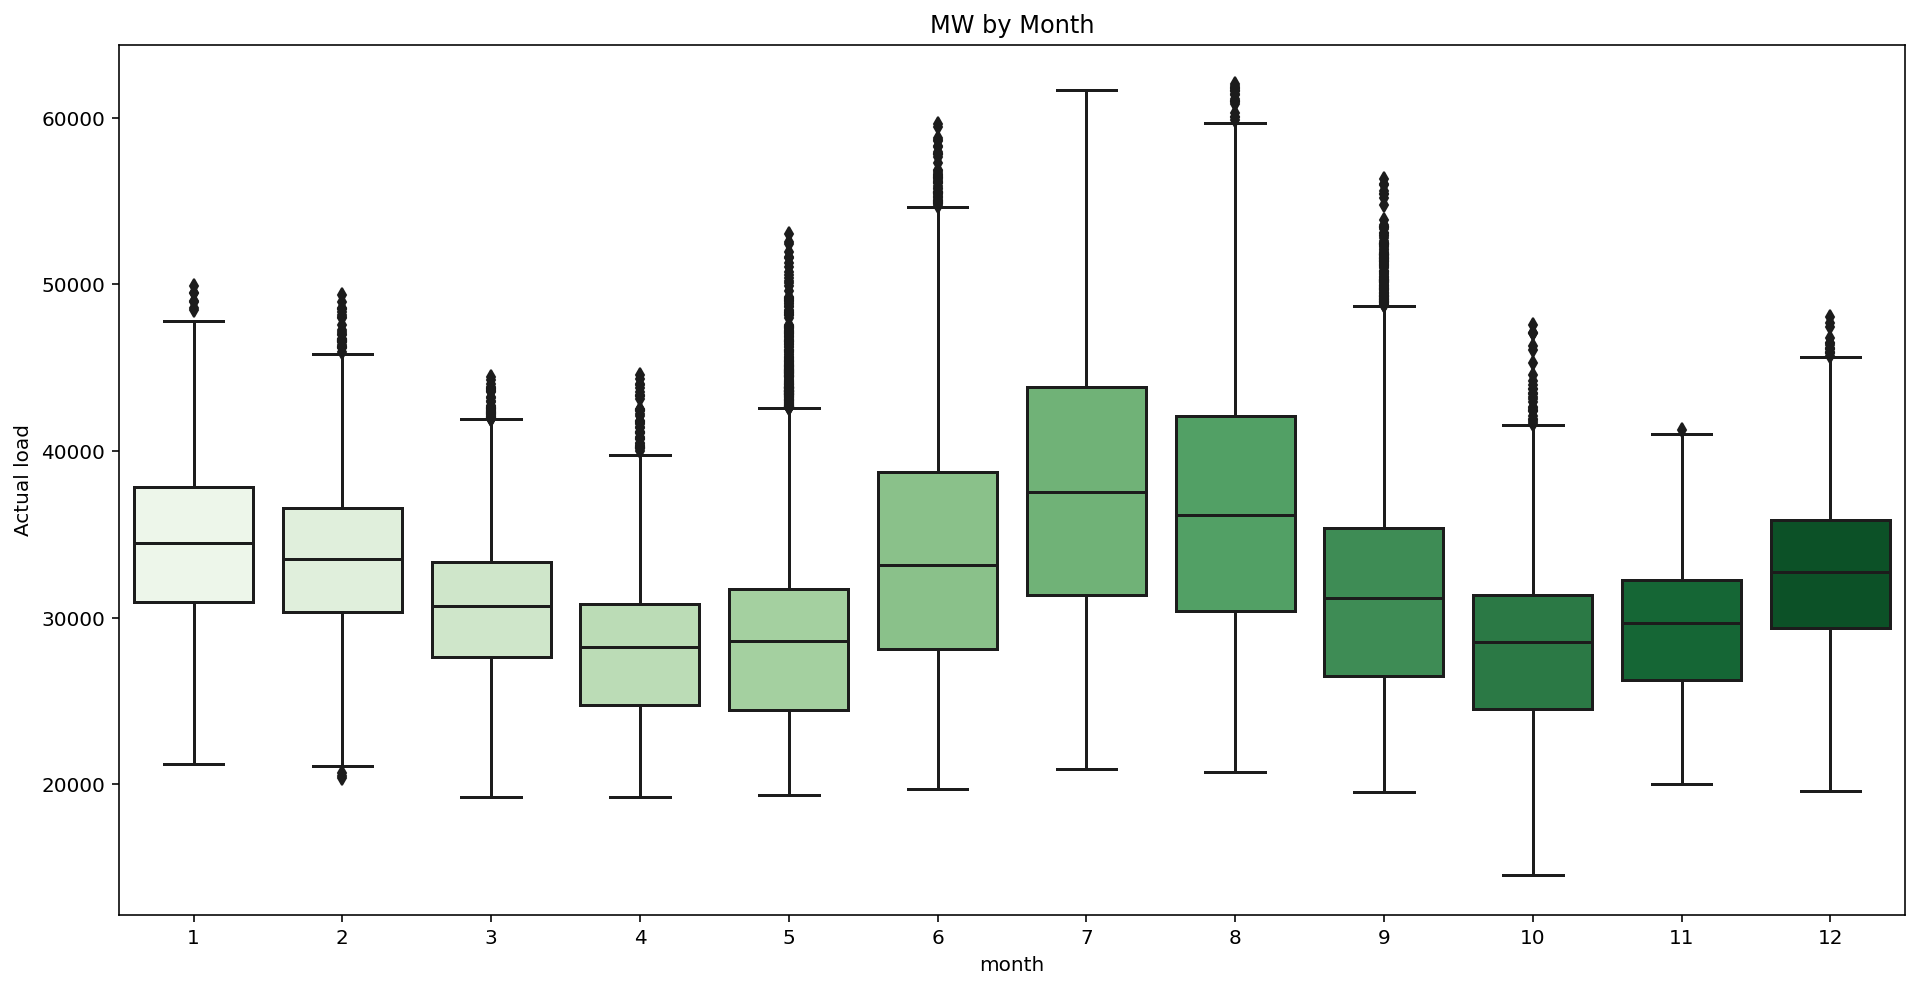

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=df, x='month', y='Actual load', palette='Greens')
ax.set_title('MW by Month')
plt.show()

> * The maximum and minimmum load occurs during the month of July and Apil respectively. 
> * July is the height of the summer in the region and the load could be peaking due to the increase in use of air conditioning. 

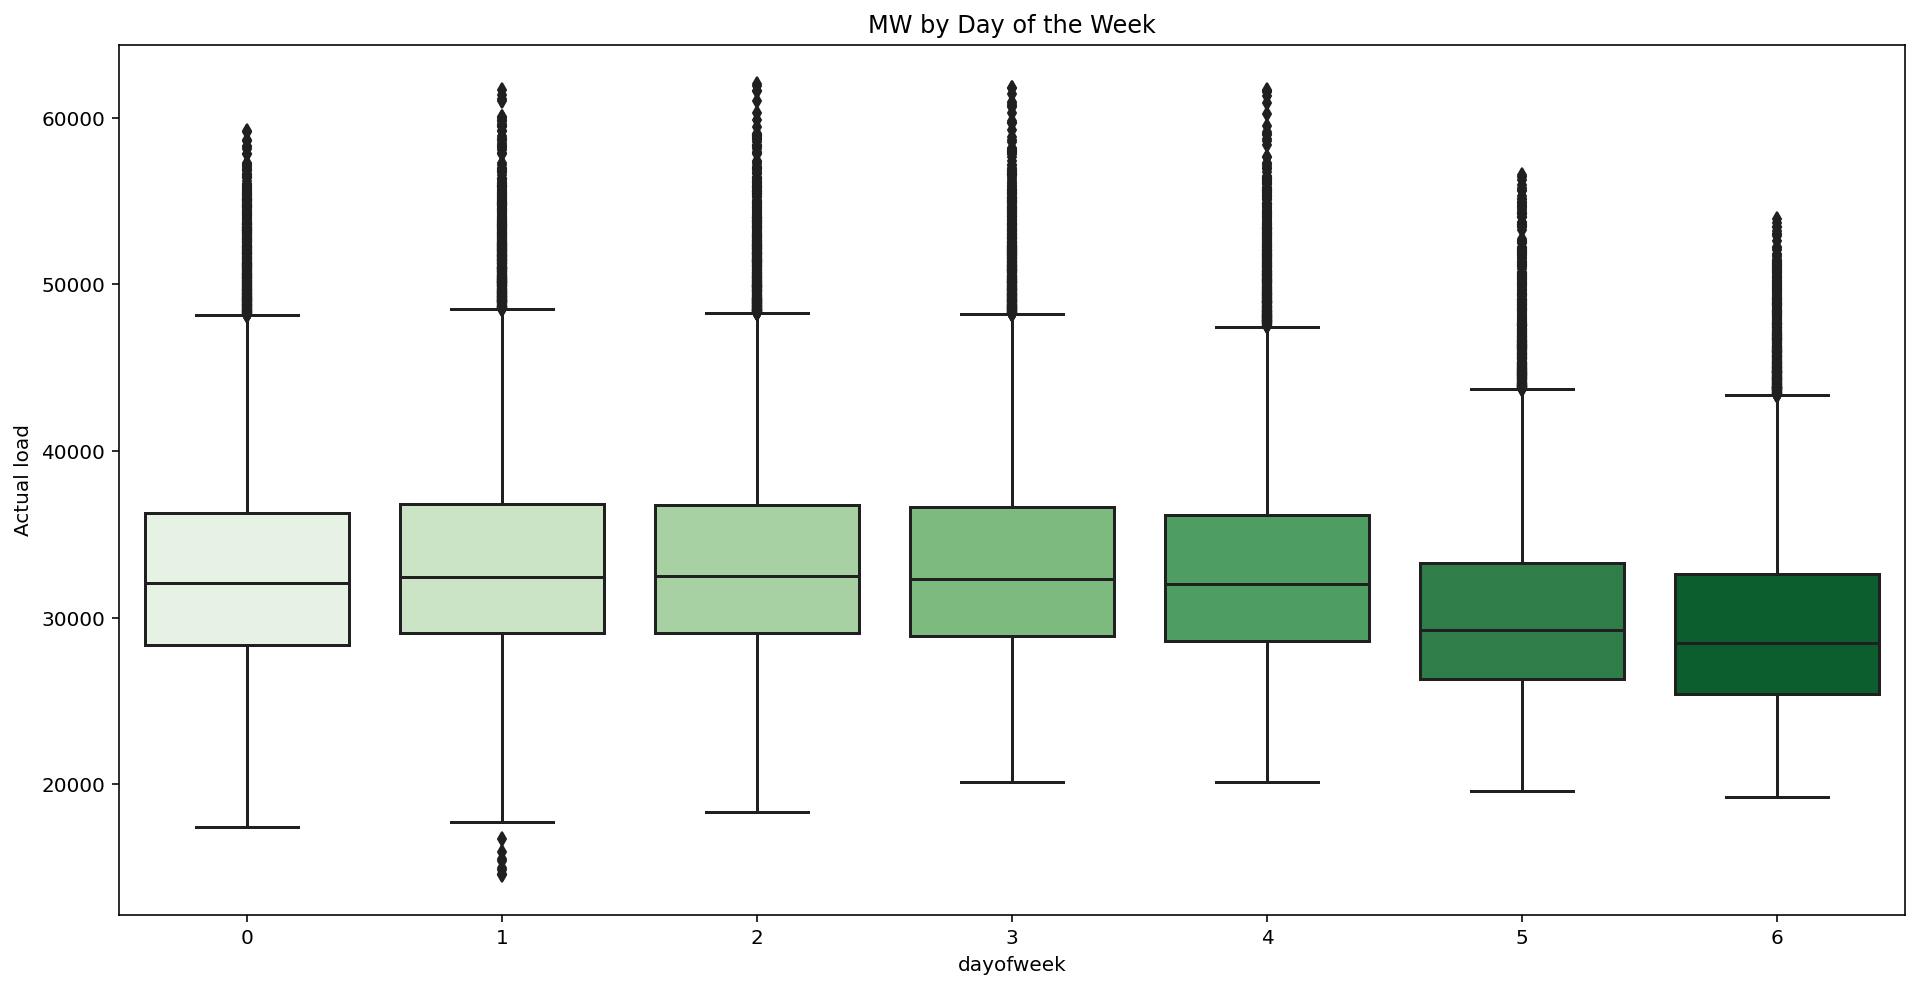

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=df, x='dayofweek', y='Actual load', palette='Greens')
ax.set_title('MW by Day of the Week')
plt.show()

> The lowest load happens during the weekend when most of the businesses are closed. 

## 3. Statistical tests

> Before we begin developing our model, we need to perform some statistical test to see whether the data is conductive to conventional statistical methods.

#### Stationarity

> First we will check for stationarity. The term "stationary" refers to a dataset's characteristics remaining constant across time. Non-stationary means that the data is influenced by factors other than the passage of time, and the trends and seasonality alter over time. The underlying qualities of a non-stationary, also referred to as a "Random Walk," are notoriously difficult to predict.

> To check the stationarity, we will use Augmented Dickey–Fuller (ADF) Test. 

> In statistics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. [Source: Wiki (https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)]

In [27]:
def adf_test(series,title=''):
    """
    Conducts an Augmented Dickey-Fuller Test on the given time series.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [28]:
# ADF test on load data

adf_test(df['Actual load'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.882891e+01
p-value                 2.022125e-30
# lags used             7.400000e+01
# observations          1.452910e+05
critical value (1%)    -3.430395e+00
critical value (5%)    -2.861560e+00
critical value (10%)   -2.566781e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


> The above test shows that the data is stationary. 

#### Autocorrelation

> Autocorrelation is the measure of how closely two points in time are related; for example, today's value is closely related to last week's value.

> We will check the autocorrelation function (ACF) and the partial autocorrelation function (PACF). PACF is a variation on ACF because it determines residual correlation after removing effects that have previously been accounted by prior lags. In this manner, a "compounding" correlation effect is avoided.

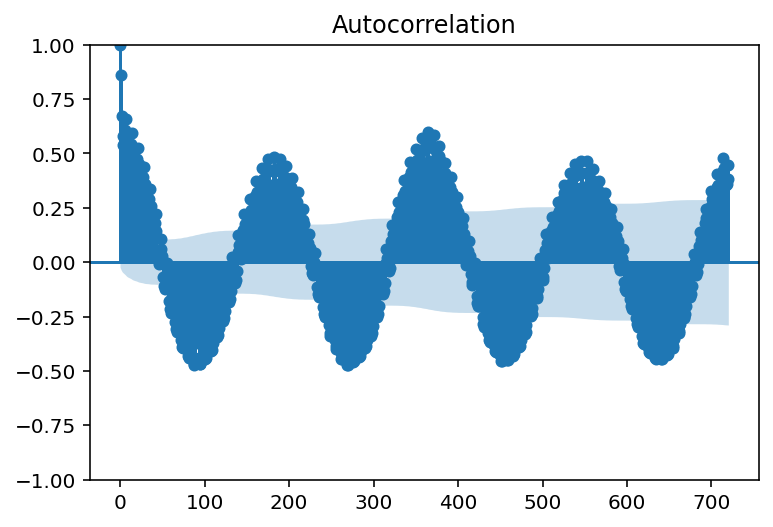

In [29]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the acf function
plot_acf(df_daily['Actual load'], lags=720)

plt.show()

> * The graph above shows the correlation between the previous point and the current point. The further away the number is from 0, the greater the correlation.

> *  In general, only all points above (for positive numbers) and below (for negative numbers) the blue shaded area (confidence interval) are considered statistically significant and worth mentioning. This indicates that yesterday's values ​​are highly correlated with today's values, indicating seasonality. This seems to repeat every 6 months.

> * As mentioned earlier, this makes sense considering the weather conditions. In winter and summer, more electricity is consumed due to the need for more heating/cooling. This could be due to the weather since electricity consumption is higher in winter and summer.

<function matplotlib.pyplot.show(close=None, block=None)>

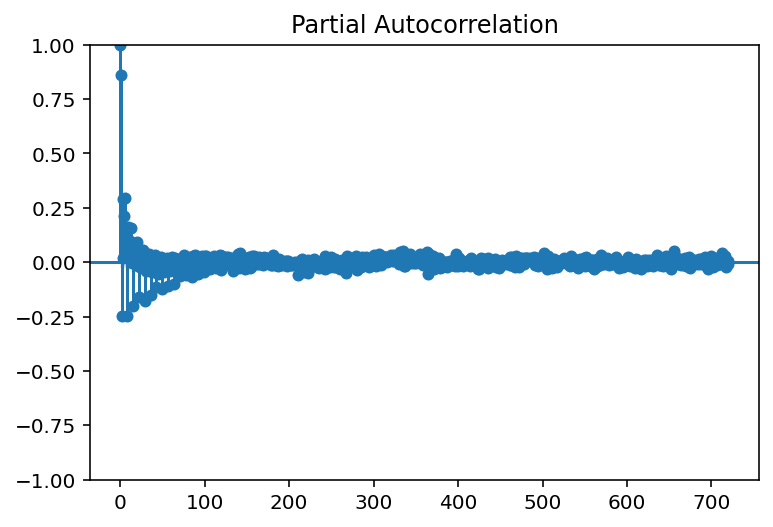

In [30]:
# Plot the pacf function
plot_pacf(df_daily['Actual load'], lags=720)

plt.show

> PACF plot shows that the last 90 days show a stronger correlation, but the farther back you go, the less obvious the effect. 

## 4. Modeling

#### Train Test Split

> We will start by splitting the data into train and test data. We will use the data beyond 2015 as the test data. The model will be trained using the data from 2002-2015. 

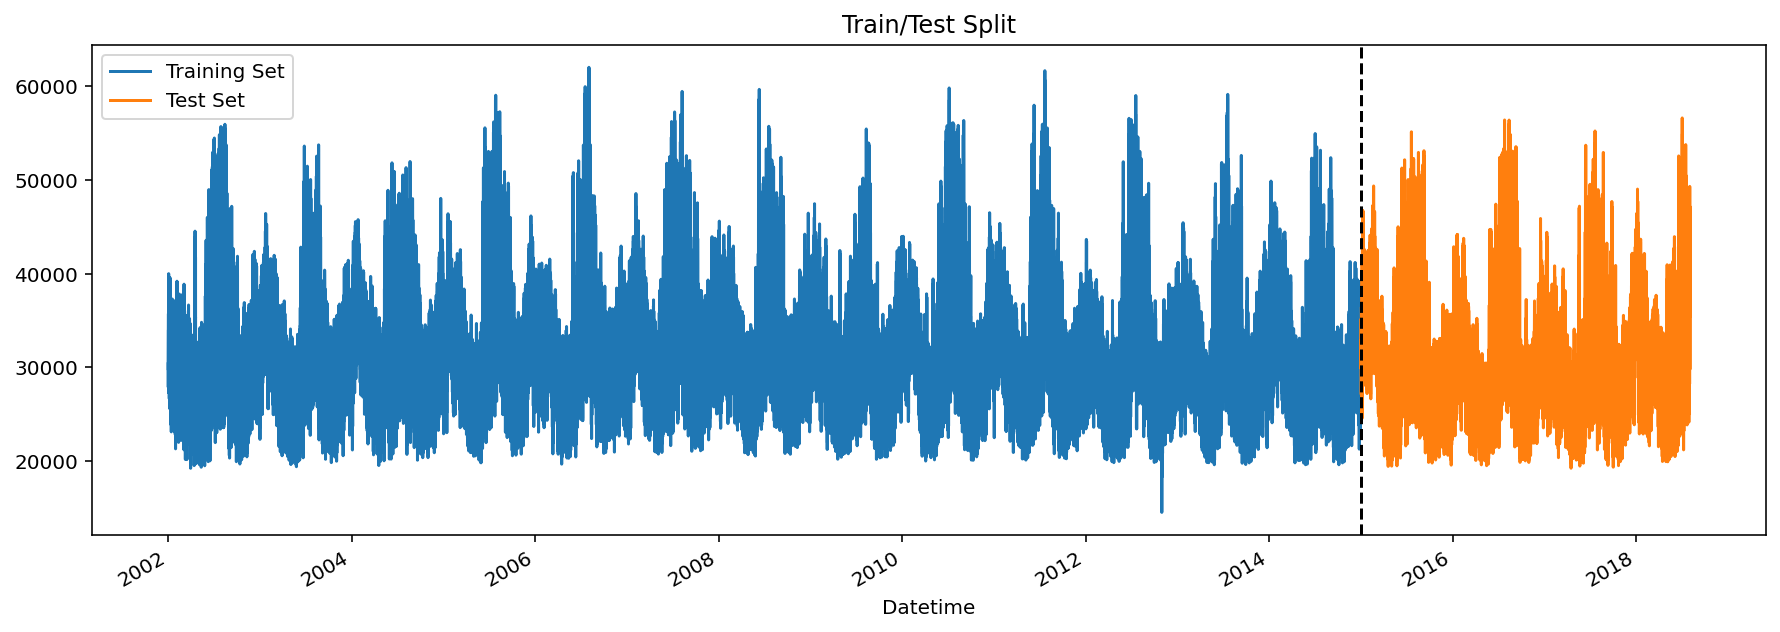

In [31]:
train = df_raw.loc[df.index < '01-01-2015']
test = df_raw.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [32]:
train

Actual load
Datetime                        
2002-12-31 01:00:00      26498.0
2002-12-31 02:00:00      25147.0
2002-12-31 03:00:00      24574.0
2002-12-31 04:00:00      24393.0
2002-12-31 05:00:00      24860.0
...                          ...
2014-01-01 20:00:00      36193.0
2014-01-01 21:00:00      35601.0
2014-01-01 22:00:00      34242.0
2014-01-01 23:00:00      32215.0
2014-01-02 00:00:00      30159.0

[113926 rows x 1 columns]

In [33]:
# Creating test and train set with features and target variable

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Actual load'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


### Model 1. Baseline model - Persistence model
 
> Before we dive into machine learning, we should establish a 'baseline' using naive forecasting approaches. That is, if the ML models cannot outperform these baseline projections, we are better off utilizing naive forecasting instead.

> They are 'naive' in the sense that they are simple to use, yet they are actually rather powerful and successful projections. There aren't many ML models that can regularly outperform a naive forecast!

> A 'One-Year-Ago Persistent Forecast' is a common naive forecast for projecting a multi-step forecast (for us, the following 365 days). This essentially means that the value for, say, January 01, 2018, is forecasted using the value for January 01, 2017.

> Here we will evaluate three types of persistence models.
    > * Previous day hour-by-hour
    > * Last 3 day average
    > * Year ago day hour-by-hour


#### Evaluation Method

> To be directly comparable to energy values in the data, models are evaluated using root mean square error (RMSE). The RMSE is calculated in two methods. To begin, consider the error of predicting one hour at a time (i.e. one error per hourly slice). Second, one value is used to indicate the model's overall performance.

> The walk forward method is used to generate forecasts. Walk forward creates forecasts by working through the samples step by step, creating a forecast at each step. After making a forecast, the test value is appended to the end of the training set and reused.

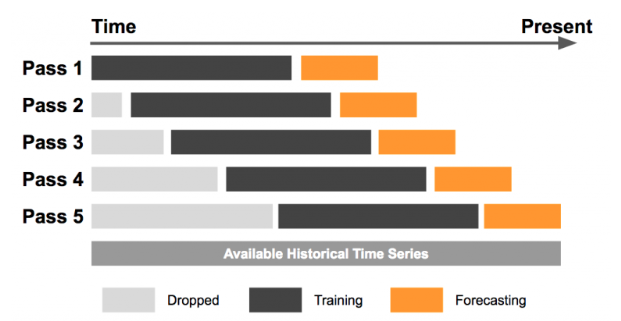


In [34]:
def walk_forward_validation(model, train_data, test_data, model_name):
    """
    Perform walk-forward validation of a predictive model.

    Args:
        model (callable): The predictive model function.
        train_data (pd.DataFrame): The training data (historical data).
        test_data (pd.DataFrame): The test data (future data).
        model_name (str): Name or identifier of the model.

    Returns:
        pd.DataFrame: DataFrame of predictions.
        dict: Dictionary of error metrics.
    """
    
    # Initialize a history of training data
    history = train_data.copy()
    
    # Initialize an empty list to store predictions
    predictions = []
    
    # Loop through each row in the test data
    for i in range(test_data.shape[0]):
        
        # Get forecasted values from the model
        Y_hat = model(history)
        
        # Store predictions
        predictions.append(Y_hat)
        
        # Get the real observation and append it to the history for the next step
        history.append(test_data.iloc[i, :])
    
    # Convert predictions to a DataFrame
    predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=test_data.columns)
    
    # Calculate errors and error mean
    errors, error_mean = calculate_errors(predictions_df, test_data, model_name)
    
    return errors, error_mean


In [35]:
# Calculating forecast errors

def calculate_errors(Y_hat_test, Y_test, result_set):
    """
    Calculate forecast errors for each hour and the average MAE.

    Args:
        Y_hat_test (pd.DataFrame): Predicted values.
        Y_test (pd.DataFrame): Actual values.
        result_set (str): Name or identifier of the result set.

    Returns:
        pd.DataFrame: DataFrame containing RMSE for each hour.
        float: Average MAE across all hours.
    """
    
    columns = [result_set]
    error_list = []
    error_mean = []
    
    # Calculate the RMSE for each hour in Y_test and Y_hat_test
    for i in range(Y_hat_test.shape[1]):
        rmse = np.sqrt(mean_squared_error(Y_hat_test.iloc[:, i], Y_test.iloc[:, i]))
        error_list.append([rmse])

    error_mean.append([
        np.mean(error_list[0])
    ])
    
    # Set an index with the 24 periods
    index = [str(x) for x in range(24)]
    
    # Store errors in a DataFrame
    errors = pd.DataFrame(error_list, index=index, columns=columns)
    
    return errors, error_mean



In [36]:
# Plotting errors

def plot_error(errors, result_set=None, title=''):
    """
    Plots error metrics from a DataFrame.

    Args:
        errors (pd.DataFrame): DataFrame containing error metrics.
        result_set (list, optional): List of error metric names to plot. Default is None.
        title (str): Title for the plot.

    Returns:
        None
    """
    
    # Create a figure for the plot
    plt.figure(figsize=(8, 7))
    
    # Get the values for the x-axis labels
    x_labels = errors.index
    
    if result_set is None:
        result_set = errors.columns
    
    # Plot each error metric in the result_set
    for result in result_set:
        plt.plot(x_labels, errors[result], label=result)

    # Set axis labels and title
    plt.ylabel('Error Metric Value')
    plt.xlabel('Hour of Day')
    plt.title(title)
    plt.legend()
    
    # Show the plot
    plt.show()


#### Model 1a: Previous day hour by hour

The previous day hour by hour model will forecast the future day hour by hour based on the energy loads from the previous day.

In [37]:
train_pivot = pd.pivot_table(train, index=train.index.date, columns=train.index.hour, values =['Actual load'])
test_pivot = pd.pivot_table(test, index=test.index.date, columns=test.index.hour, values =['Actual load'])

train_pivot = train_pivot.dropna()
test_pivot = test_pivot.dropna()

In [38]:
def day_hbh_persistence(history, days=1):
    """
    Generate a persistence forecast for a given number of days based on historical data.

    Args:
        history (pd.DataFrame): Historical data with days as the index and hours in the day as columns.
        days (int): Number of days to forecast. Default is 1.

    Returns:
        pd.Series: Forecast for the specified number of days.
    """
    # Return the last week in the history data set as the forecast for the next week.
    return history.iloc[-days, :]


In [39]:
errors_day, error_mean_day = walk_forward_validation(day_hbh_persistence, train_pivot, test_pivot, "prev_day_persistence")

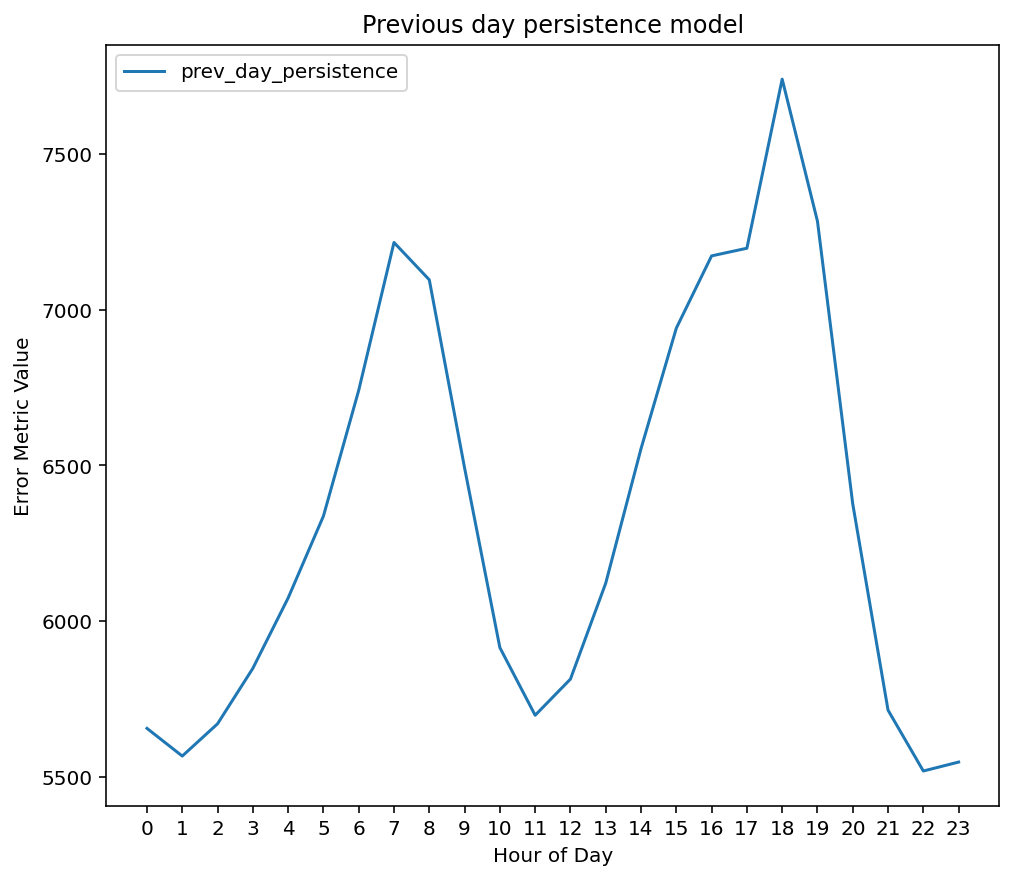

In [40]:
plot_error(errors_day, result_set=['prev_day_persistence'], title='Previous day persistence model')

In [41]:
errors_day.head(3)

prev_day_persistence
0           5655.368895
1           5566.424405
2           5670.083092

#### Model 1b: Moving average of last 3 days



In [42]:
def moving_average_persistence(history, window=3):
    """
    Generate a moving average-based persistence forecast for the next time step.

    Args:
        history (pd.DataFrame): Historical data with days as the index and hours in the day as columns.
        window (int): Number of time steps to include in the moving average. Default is 3.

    Returns:
        pd.Series: Forecast based on the moving average of the specified window.
    """
    
    # Calculate the moving average forecast
    prediction = history.rolling(window).mean().iloc[-1, :]
    
    return prediction

In [44]:
errors_ma, error_mean_ma = walk_forward_validation(moving_average_persistence, train_pivot, test_pivot, "ma_persistence")

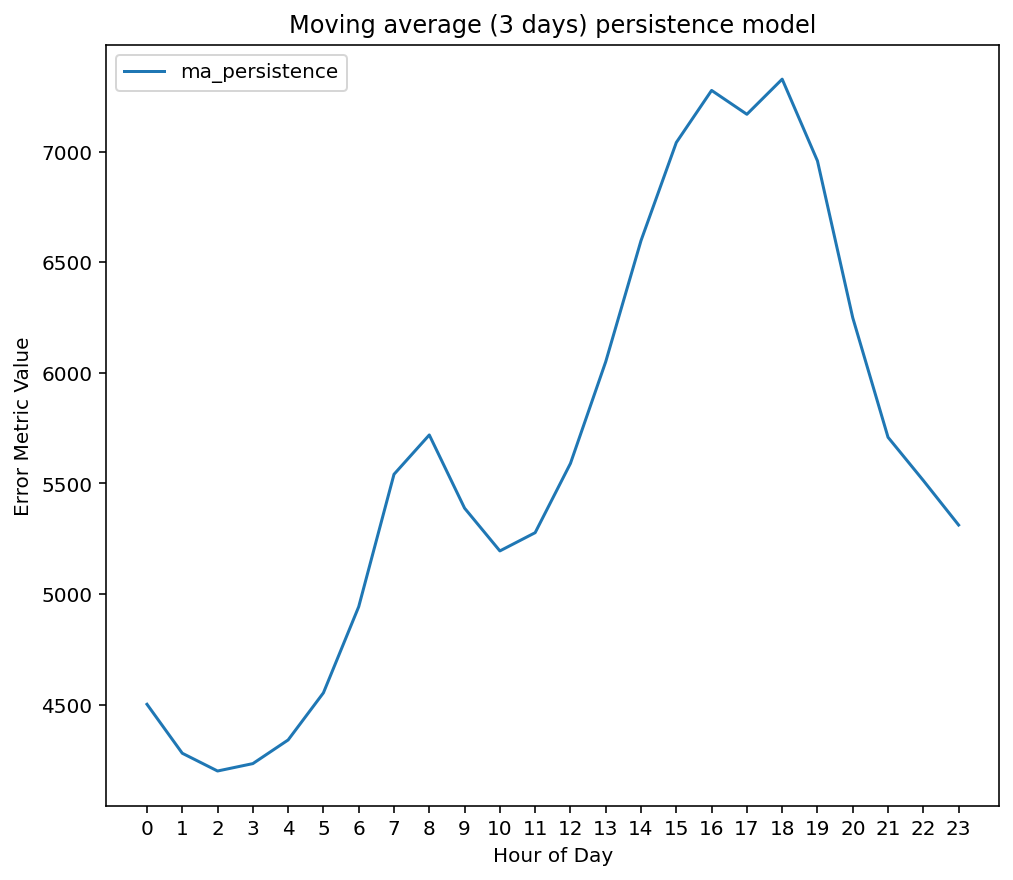

In [45]:
plot_error(errors_ma, result_set=['ma_persistence'], title='Moving average (3 days) persistence model')

#### Model 1c: Same day previous year hour by hour

In [46]:
def same_day_oya_persistence(history):
    """
    History is a dataframe with index as days, and columns hours in the day. 
    
    """
    
    #retrns the same week one year ago as the forecast for the next week.

    #set the current date to the last day in the history set
    day_oya = history.index[-1]
    
    #history contains up to the last day in the trianing file. We want to predict the next day, using the data from one year ago.
    day_oya += dt.timedelta(days=-365)
    
    prediction = history.loc[day_oya,:]
    
    return prediction

In [47]:
def same_day_one_year_ago_persistence(history):
    """
    Generate a persistence forecast using data from the same day one year ago.

    Args:
        history (pd.DataFrame): Historical data with days as the index and hours in the day as columns.

    Returns:
        pd.Series: Forecast based on data from the same day one year ago.
    """
    
    # Calculate the date one year ago from the last day in the history set
    day_oya = history.index[-1]
    day_oya += dt.timedelta(days=-365)
    
    # Retrieve the data for the same day one year ago as the forecast
    prediction = history.loc[day_oya, :]
    
    return prediction


In [48]:
errors_oya, error_mean_oya = walk_forward_validation(same_day_oya_persistence, train_pivot, test_pivot, "same_day_oya_persistence")

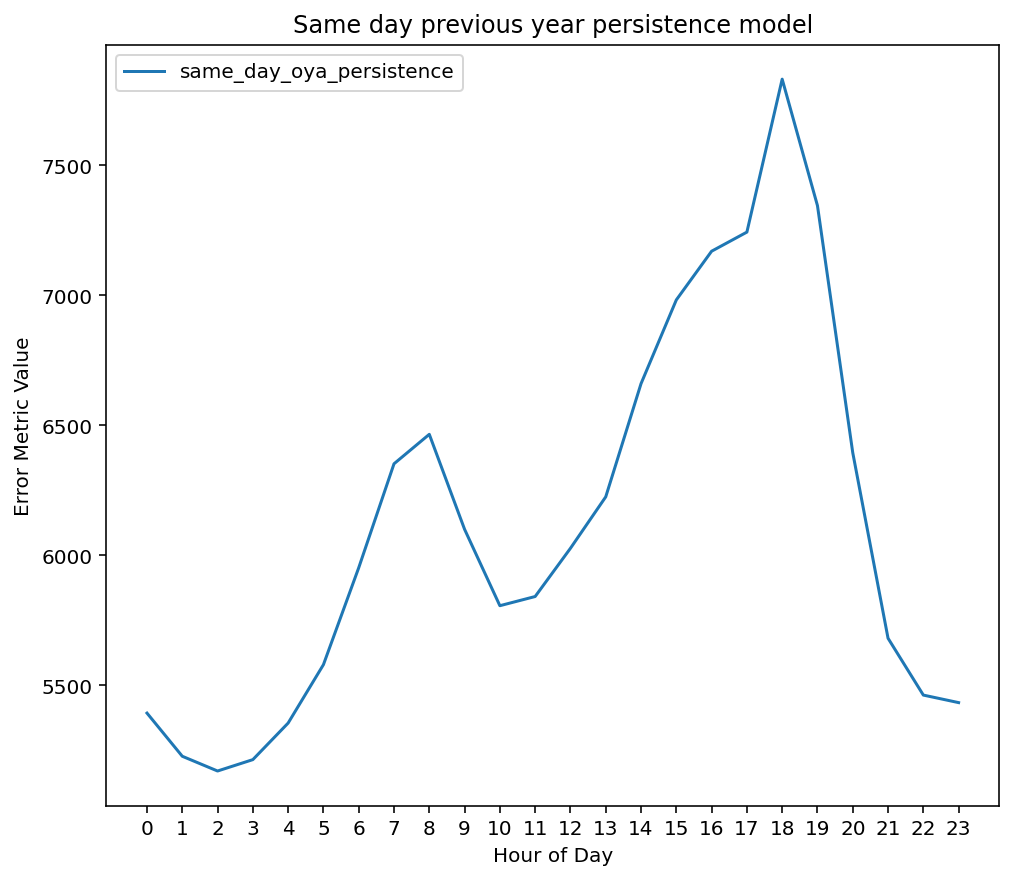

In [49]:
plot_error(errors_oya, result_set=['same_day_oya_persistence'], title='Same day previous year persistence model')

In [50]:
#combine the errors from both models into one dataframe

errors = pd.concat([errors_day, errors_ma, errors_oya], axis=1)
errors.head(3)

prev_day_persistence  ma_persistence  same_day_oya_persistence
0           5655.368895     4501.322966               5393.111318
1           5566.424405     4279.957319               5227.080033
2           5670.083092     4199.643477               5170.327555

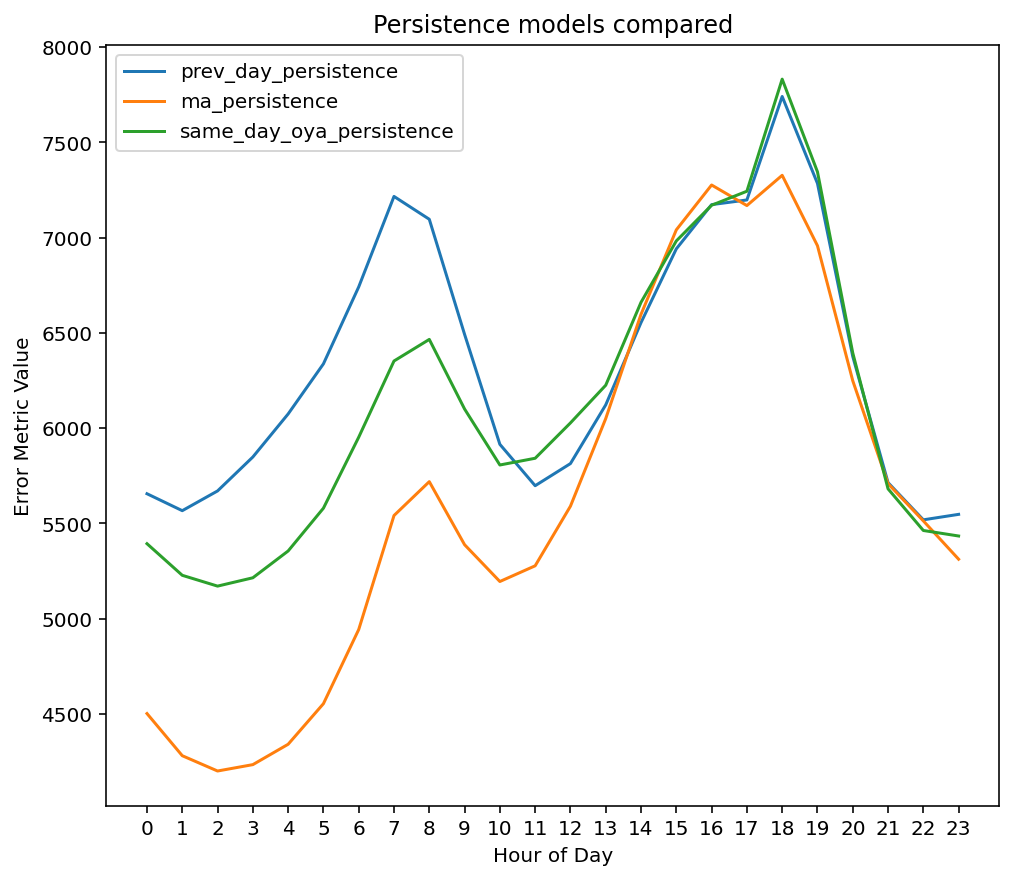

In [51]:
result_set = ['prev_day_persistence', "ma_persistence", 'same_day_oya_persistence']
plot_error(errors, result_set=result_set, title='Persistence models compared')

> The moving average model seems to be the better one among the 3 persistence models. There is a lot of variation between the predictions in the hours from 0 to 12. 

> This will be the baseline error against which we will test the other advanced models. 

### Model 2. XGBoost

XGBoost is a fast gradient boosting implementation for classification and regression tasks.

It is both fast and efficient, and it excels at, if not outperforms, a wide range of predictive modeling jobs. It can also be used to forecast time series.

In [52]:
# Create an XGBoost Regressor with specified parameters
reg = xgb.XGBRegressor(n_estimators=1000)

# Fit the model with early stopping and optional verbosity
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=False  # Set to True if you want to see training progress
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

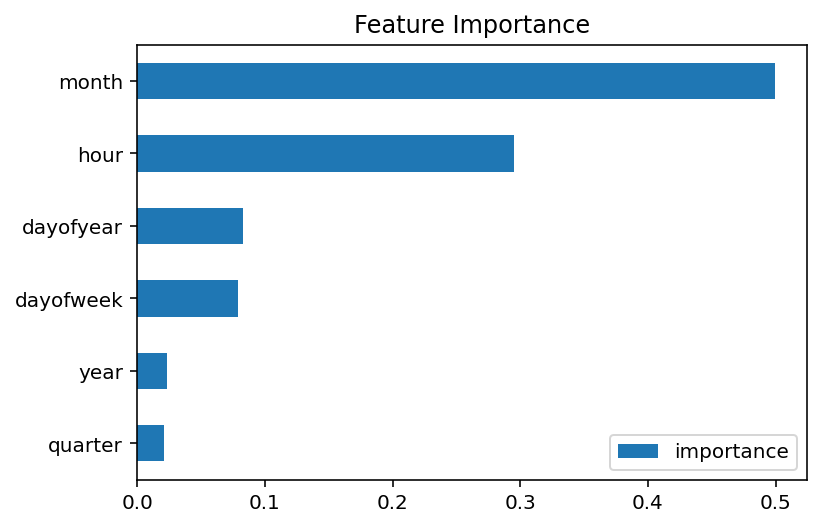

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame to store feature importances
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

# Sort the DataFrame by importance and plot as a horizontal bar chart
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

# Display the plot
plt.show()


> In energy demand forecasting, we found that two factors stand out as highly important: the "month of the year" and the "hour of the day."

> * Month of the Year: Different months have distinct effects on energy use due to factors like weather, holidays, and economic activities. Accurately accounting for these seasonal patterns is crucial.

> * Hour of the Day: Energy demand follows specific daily patterns, with peak usage during business hours and lower usage at night. Understanding these daily fluctuations is vital for efficient energy management.

> These two factors play a significant role in predicting energy demand accurately.

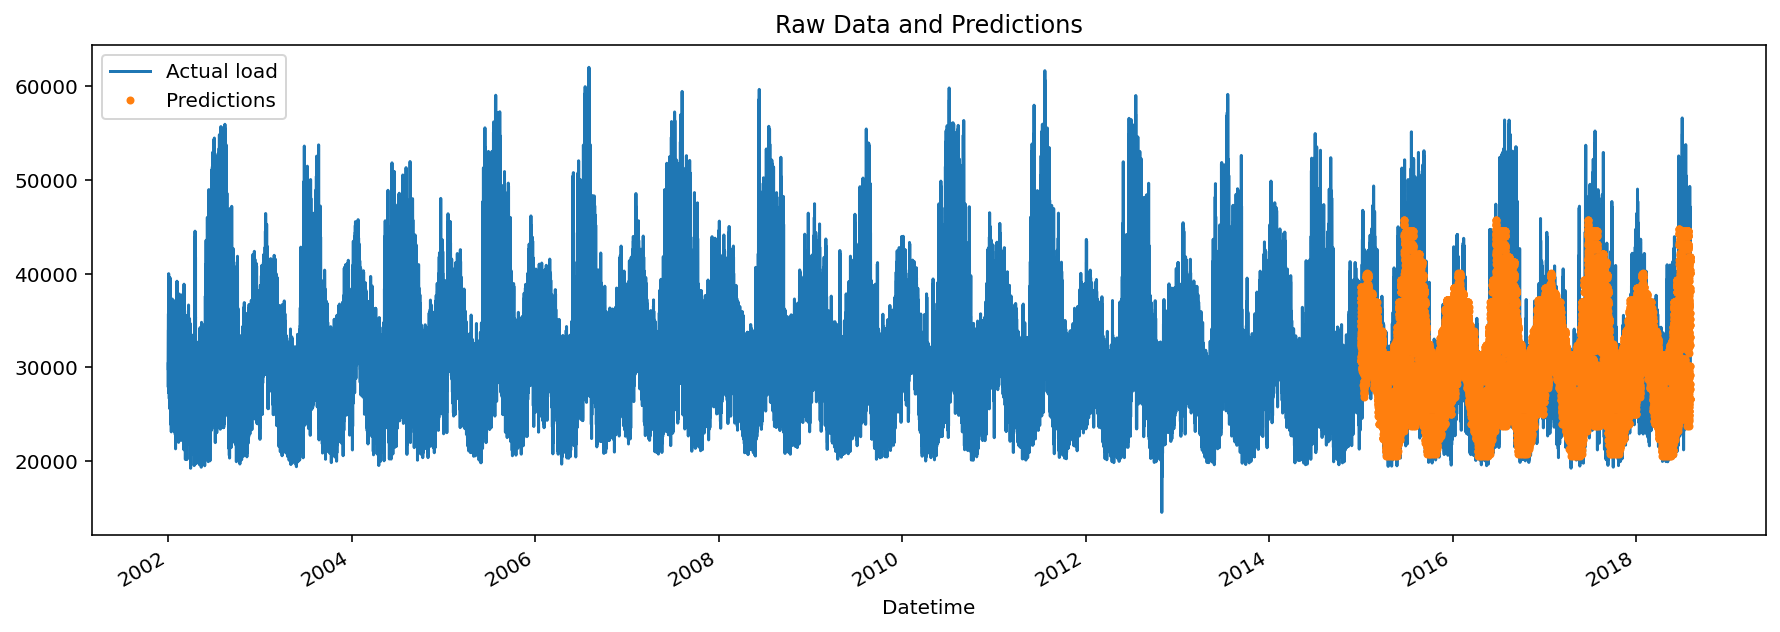

In [54]:
# Make predictions using the trained model
test['prediction'] = reg.predict(X_test)

# Merge the prediction column from 'test' into the main DataFrame 'df'
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Create a plot with actual load and predictions
ax = df[['Actual load']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')

# Add legend and set the title
plt.legend(['Actual load', 'Predictions'])
ax.set_title('Raw Data and Predictions')

# Display the plot
plt.show()


In [55]:
df

Actual load  hour  dayofweek  quarter  month  year  \
Datetime                                                                  
2002-01-01 01:00:00      30393.0     1          1        1      1  2002   
2002-01-01 02:00:00      29265.0     2          1        1      1  2002   
2002-01-01 03:00:00      28357.0     3          1        1      1  2002   
2002-01-01 04:00:00      27899.0     4          1        1      1  2002   
2002-01-01 05:00:00      28057.0     5          1        1      1  2002   
...                          ...   ...        ...      ...    ...   ...   
2018-08-02 20:00:00      44057.0    20          3        3      8  2018   
2018-08-02 21:00:00      43256.0    21          3        3      8  2018   
2018-08-02 22:00:00      41552.0    22          3        3      8  2018   
2018-08-02 23:00:00      38500.0    23          3        3      8  2018   
2018-08-03 00:00:00      35486.0     0          4        3      8  2018   

                     dayofyear  dayofmonth  weekofyear    prediction  
Datetime                                                              
2002-01-01 01:00:00          1           1           1           NaN  
2002-01-01 02:00:00          1           1           1           NaN  
2002-01-01 03:00:00          1           1           1           NaN  
2002-01-01 04:00:00          1           1           1           NaN  
2002-01-01 05:00:00          1           1           1           NaN  
...                        ...         ...         ...           ...  
2018-08-02 20:00:00        214           2          31  40108.804688  
2018-08-02 21:00:00        214           2          31  40108.804688  
2018-08-02 22:00:00        214           2          31  38110.726562  
2018-08-02 23:00:00        214           2          31  34509.949219  
2018-08-03 00:00:00        215           3          31  33253.828125  

[145372 rows x 10 columns]

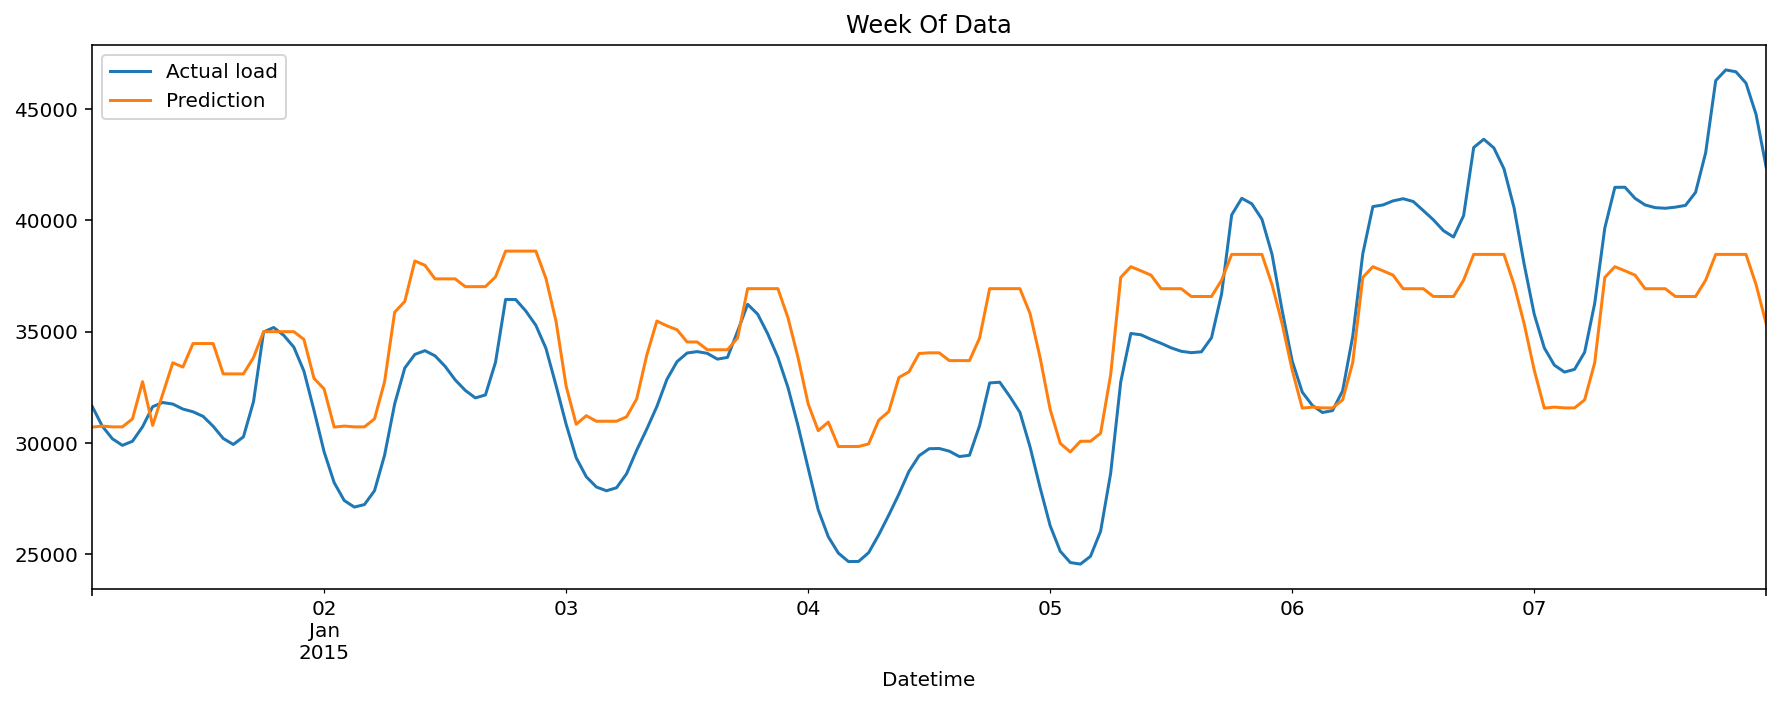

In [60]:
plt.figure()

# Filter and plot data for the week of '01-01-2015' to '01-08-2015'
ax = df.loc[(df.index > '01-01-2015') & (df.index < '01-08-2015')]['Actual load'] \
    .plot(figsize=(15, 5), title='Week Of Data')

# Plot predictions for the same week
df.loc[(df.index > '01-01-2015') & (df.index < '01-08-2015')]['prediction'] \
    .plot(style='-', ax=ax)

# Add legend and display the plot
plt.legend(['Actual load', 'Prediction'])
plt.show()


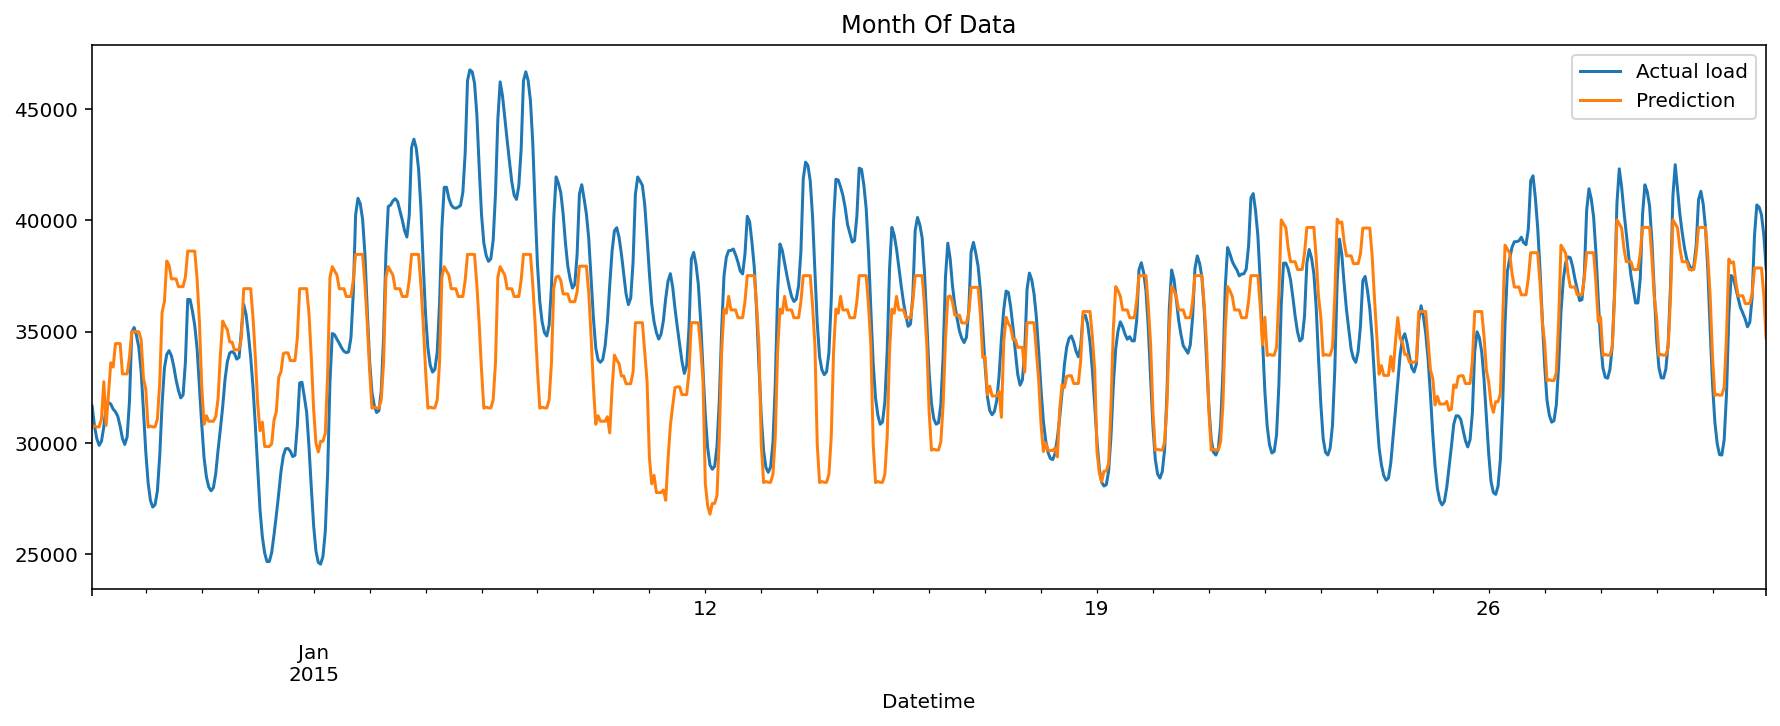

In [64]:
# Filter and plot data for the month of January 2015
ax = df.loc[(df.index > '01-01-2015') & (df.index < '01-31-2015')]['Actual load'] \
    .plot(figsize=(15, 5), title='Month Of Data')

# Plot predictions for the same month
df.loc[(df.index > '01-01-2015') & (df.index < '01-31-2015')]['prediction'] \
    .plot(style='-', ax=ax)

# Add legend and display the plot
plt.legend(['Actual load', 'Prediction'])
plt.show()


In [65]:
score = np.sqrt(mean_squared_error(test['Actual load'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3763.35


> * The error values from the XGBoost model are lower than the baseline model. 

> * The XGBoost model is able to give a decent prediction of the actual load. The main difference between the actual and predicted load comes at peaks. 

## Conclusion


> * The effect of weather will have to be included to improve the predictions. 

> * Other models that can be tried for energy demand forecasting includes RNNs and LSTMs. 

> * Feature engineering techniques like lag analysis can be used.

For a more detailed conclusion, please see the final project report. 